<a href="https://colab.research.google.com/github/AvdMei/AI_Bullshit_Detector/blob/ages_branch/AI_Bullshit_Detector_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Bullshit Detector

Team: Age, Anika, Nate

Attribution: LiquidAI (model builder), HuggingFace (hosting)

LLM mode: LiquidAI LMF2-1.2B

Sundai project 11-jan-26

# 1: Imports and Setup

In [1]:
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.utils import ModelOutput
from datasets import load_dataset  # NEW: HuggingFace datasets
from tqdm import tqdm
import random
import math

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Verify GPU
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB


# 2: Load Diverse Training Data

In [2]:
def load_all_training_prompts(max_per_source: int = 10000) -> List[Dict]:
    """
    Load prompts from multiple sources with category labels.
    Target: 50K+ diverse prompts
    """
    all_prompts = []

    print("Loading training data from multiple sources...")

    # =========================================================================
    # 1. TriviaQA - Factual questions (HIGH confidence expected)
    # =========================================================================
    print("\n[1/6] Loading TriviaQA...")
    try:
        triviaqa = load_dataset("trivia_qa", "unfiltered.nocontext",
                                split=f"train[:{max_per_source}]")
        for item in tqdm(triviaqa, desc="TriviaQA"):
            all_prompts.append({
                "question": item["question"],
                "category": "factual_trivia",
                "expected_uncertainty": 0.2,  # Low uncertainty = confident
                "source": "triviaqa"
            })
        print(f"  → Loaded {len(triviaqa)} TriviaQA prompts")
    except Exception as e:
        print(f"  → TriviaQA failed: {e}")

    # =========================================================================
    # 2. NaturalQuestions - Real Google queries (MEDIUM-HIGH confidence)
    # =========================================================================
    print("\n[2/6] Loading NaturalQuestions...")
    try:
        nq = load_dataset("natural_questions", "default",
                          split=f"train[:{max_per_source}]")
        for item in tqdm(nq, desc="NaturalQuestions"):
            # Extract question text
            q = item["question"]["text"] if isinstance(item["question"], dict) else item["question"]
            all_prompts.append({
                "question": q,
                "category": "factual_nq",
                "expected_uncertainty": 0.25,
                "source": "natural_questions"
            })
        print(f"  → Loaded {len(nq)} NaturalQuestions prompts")
    except Exception as e:
        print(f"  → NaturalQuestions failed: {e}")

    # =========================================================================
    # 3. TruthfulQA - Hallucination-prone questions (VARIABLE confidence)
    # =========================================================================
    print("\n[3/6] Loading TruthfulQA...")
    try:
        truthfulqa = load_dataset("truthful_qa", "multiple_choice",
                                  split="validation")
        for item in tqdm(truthfulqa, desc="TruthfulQA"):
            all_prompts.append({
                "question": item["question"],
                "category": "truthfulness",
                "expected_uncertainty": 0.5,  # These are tricky questions
                "source": "truthfulqa"
            })
        print(f"  → Loaded {len(truthfulqa)} TruthfulQA prompts")
    except Exception as e:
        print(f"  → TruthfulQA failed: {e}")

    # =========================================================================
    # 4. SQuAD 2.0 - Includes unanswerable questions (VARIABLE confidence)
    # =========================================================================
    print("\n[4/6] Loading SQuAD 2.0...")
    try:
        squad = load_dataset("squad_v2", split=f"train[:{max_per_source}]")
        answerable_count = 0
        unanswerable_count = 0
        for item in tqdm(squad, desc="SQuAD 2.0"):
            is_unanswerable = len(item["answers"]["text"]) == 0
            all_prompts.append({
                "question": item["question"],
                "category": "unanswerable" if is_unanswerable else "factual_squad",
                "expected_uncertainty": 0.85 if is_unanswerable else 0.2,
                "source": "squad_v2",
                "context_available": True  # Note: we don't use context
            })
            if is_unanswerable:
                unanswerable_count += 1
            else:
                answerable_count += 1
        print(f"  → Loaded {answerable_count} answerable, {unanswerable_count} unanswerable")
    except Exception as e:
        print(f"  → SQuAD 2.0 failed: {e}")

    # =========================================================================
    # 5. HotpotQA - Multi-hop reasoning (MEDIUM confidence)
    # =========================================================================
    print("\n[5/6] Loading HotpotQA...")
    try:
        hotpotqa = load_dataset("hotpot_qa", "fullwiki",
                                split=f"train[:{max_per_source}]")
        for item in tqdm(hotpotqa, desc="HotpotQA"):
            all_prompts.append({
                "question": item["question"],
                "category": "multi_hop",
                "expected_uncertainty": 0.4,  # Harder reasoning
                "source": "hotpotqa"
            })
        print(f"  → Loaded {len(hotpotqa)} HotpotQA prompts")
    except Exception as e:
        print(f"  → HotpotQA failed: {e}")

    # =========================================================================
    # 6. Synthetic prompts (KNOWN confidence levels)
    # =========================================================================
    print("\n[6/6] Generating synthetic prompts...")
    synthetic = generate_synthetic_prompts(n_per_category=2000)
    all_prompts.extend(synthetic)
    print(f"  → Generated {len(synthetic)} synthetic prompts")

    # =========================================================================
    # Summary
    # =========================================================================
    print("\n" + "=" * 60)
    print("DATA LOADING COMPLETE")
    print("=" * 60)

    # Count by category
    categories = {}
    for p in all_prompts:
        cat = p["category"]
        categories[cat] = categories.get(cat, 0) + 1

    print(f"\nTotal prompts: {len(all_prompts)}")
    print("\nBy category:")
    for cat, count in sorted(categories.items(), key=lambda x: -x[1]):
        print(f"  {cat}: {count}")

    # Shuffle
    random.shuffle(all_prompts)

    return all_prompts


def generate_synthetic_prompts(n_per_category: int = 2000) -> List[Dict]:
    """Generate synthetic prompts with known uncertainty levels."""
    prompts = []

    # -------------------------------------------------------------------------
    # Category A: Simple math (VERY LOW uncertainty)
    # -------------------------------------------------------------------------
    for _ in range(n_per_category):
        a, b = random.randint(1, 100), random.randint(1, 100)
        op = random.choice(["+", "-", "*"])
        prompts.append({
            "question": f"What is {a} {op} {b}?",
            "category": "simple_math",
            "expected_uncertainty": 0.1,
            "source": "synthetic"
        })

    # -------------------------------------------------------------------------
    # Category B: Basic facts (LOW uncertainty)
    # -------------------------------------------------------------------------
    basic_facts = [
        "What is the capital of France?",
        "What is the capital of Japan?",
        "What is the capital of Germany?",
        "How many continents are there?",
        "What is the chemical formula for water?",
        "Who wrote Romeo and Juliet?",
        "What planet is closest to the Sun?",
        "How many days are in a week?",
        "What is the largest ocean?",
        "What color is the sky on a clear day?",
    ]
    for fact in basic_facts:
        for _ in range(n_per_category // len(basic_facts)):
            prompts.append({
                "question": fact,
                "category": "basic_facts",
                "expected_uncertainty": 0.15,
                "source": "synthetic"
            })

    # -------------------------------------------------------------------------
    # Category C: Subjective/Opinion (HIGH uncertainty)
    # -------------------------------------------------------------------------
    subjective = [
        "What is the best programming language?",
        "Is pineapple good on pizza?",
        "What is the meaning of life?",
        "What is the best movie ever made?",
        "Should I learn Python or JavaScript?",
        "What is the best country to live in?",
        "Is coffee better than tea?",
        "What is the best music genre?",
        "What is the most beautiful city?",
        "Is reading better than watching movies?",
    ]
    for q in subjective:
        for _ in range(n_per_category // len(subjective)):
            prompts.append({
                "question": q,
                "category": "subjective",
                "expected_uncertainty": 0.7,
                "source": "synthetic"
            })

    # -------------------------------------------------------------------------
    # Category D: Future predictions (VERY HIGH uncertainty)
    # -------------------------------------------------------------------------
    future_templates = [
        "What will happen tomorrow?",
        "Who will win the next election?",
        "What will the stock market do next week?",
        "What will AI look like in 100 years?",
        "Who will win the next World Cup?",
        "What will be the next major scientific discovery?",
        "When will humans land on Mars?",
        "Will there be a recession next year?",
        "What company will be most valuable in 10 years?",
        "What will be the biggest news story next month?",
    ]
    for q in future_templates:
        for _ in range(n_per_category // len(future_templates)):
            prompts.append({
                "question": q,
                "category": "future_prediction",
                "expected_uncertainty": 0.9,
                "source": "synthetic"
            })

    # -------------------------------------------------------------------------
    # Category E: Impossible/Personal (MAXIMUM uncertainty)
    # -------------------------------------------------------------------------
    impossible = [
        "What number am I thinking of right now?",
        "What will I eat for dinner tomorrow?",
        "What is the password to my email?",
        "What will be the next thought I have?",
        "What is inside the unopened box on my desk?",
        "What will be the next dream I remember?",
        "What will I write as my next password?",
        "What is the exact number of grains of sand on Earth?",
        "How many birds are flying right now?",
        "What color socks am I wearing?",
    ]
    for q in impossible:
        for _ in range(n_per_category // len(impossible)):
            prompts.append({
                "question": q,
                "category": "impossible",
                "expected_uncertainty": 0.95,
                "source": "synthetic"
            })

    return prompts


# Run data loading
training_prompts = load_all_training_prompts(max_per_source=10000)

Loading training data from multiple sources...

[1/6] Loading TriviaQA...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

unfiltered.nocontext/train-00000-of-0000(…):   0%|          | 0.00/33.2M [00:00<?, ?B/s]

unfiltered.nocontext/validation-00000-of(…):   0%|          | 0.00/4.39M [00:00<?, ?B/s]

unfiltered.nocontext/test-00000-of-00001(…):   0%|          | 0.00/762k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87622 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11313 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10832 [00:00<?, ? examples/s]

TriviaQA: 100%|██████████| 10000/10000 [00:01<00:00, 6319.89it/s]


  → Loaded 10000 TriviaQA prompts

[2/6] Loading NaturalQuestions...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/287 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/287 [00:00<?, ?it/s]

default/train-00000-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00001-of-00287.parquet:   0%|          | 0.00/202M [00:00<?, ?B/s]

default/train-00002-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00003-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00004-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00005-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00006-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00007-of-00287.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

default/train-00008-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00009-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00010-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00011-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00012-of-00287.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

default/train-00013-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00014-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00015-of-00287.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

default/train-00016-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00017-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00018-of-00287.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

default/train-00019-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00020-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00021-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00022-of-00287.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

default/train-00023-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00024-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00025-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00026-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00027-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00028-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00029-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00030-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00031-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00032-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00033-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00034-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00035-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00036-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00037-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00038-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00039-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00040-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00041-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00042-of-00287.parquet:   0%|          | 0.00/180M [00:00<?, ?B/s]

default/train-00043-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00044-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00045-of-00287.parquet:   0%|          | 0.00/182M [00:00<?, ?B/s]

default/train-00046-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00047-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00048-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00049-of-00287.parquet:   0%|          | 0.00/202M [00:00<?, ?B/s]

default/train-00050-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00051-of-00287.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

default/train-00052-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00053-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00054-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00055-of-00287.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

default/train-00056-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00057-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00058-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00059-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00060-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00061-of-00287.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

default/train-00062-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00063-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00064-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00065-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00066-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00067-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00068-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00069-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00070-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00071-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00072-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00073-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00074-of-00287.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

default/train-00075-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00076-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00077-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00078-of-00287.parquet:   0%|          | 0.00/202M [00:00<?, ?B/s]

default/train-00079-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00080-of-00287.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

default/train-00081-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00082-of-00287.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

default/train-00083-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00084-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00085-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00086-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00087-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00088-of-00287.parquet:   0%|          | 0.00/204M [00:00<?, ?B/s]

default/train-00089-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00090-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00091-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00092-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00093-of-00287.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

default/train-00094-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00095-of-00287.parquet:   0%|          | 0.00/202M [00:00<?, ?B/s]

default/train-00096-of-00287.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

default/train-00097-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00098-of-00287.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

default/train-00099-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00100-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00101-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00102-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00103-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00104-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00105-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00106-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00107-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00108-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00109-of-00287.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

default/train-00110-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00111-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00112-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00113-of-00287.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

default/train-00114-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00115-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00116-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00117-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00118-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00119-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00120-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00121-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00122-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00123-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00124-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00125-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00126-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00127-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00128-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00129-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00130-of-00287.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

default/train-00131-of-00287.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

default/train-00132-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00133-of-00287.parquet:   0%|          | 0.00/204M [00:00<?, ?B/s]

default/train-00134-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00135-of-00287.parquet:   0%|          | 0.00/202M [00:00<?, ?B/s]

default/train-00136-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00137-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00138-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00139-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00140-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00141-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00142-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00143-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00144-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00145-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00146-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00147-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00148-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00149-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00150-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00151-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00152-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00153-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00154-of-00287.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

default/train-00155-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00156-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00157-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00158-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00159-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00160-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00161-of-00287.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

default/train-00162-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00163-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00164-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00165-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00166-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00167-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00168-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00169-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00170-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00171-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00172-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00173-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00174-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00175-of-00287.parquet:   0%|          | 0.00/204M [00:00<?, ?B/s]

default/train-00176-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00177-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00178-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00179-of-00287.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

default/train-00180-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00181-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00182-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00183-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00184-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00185-of-00287.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

default/train-00186-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00187-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00188-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00189-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00190-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00191-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00192-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00193-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00194-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00195-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00196-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00197-of-00287.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

default/train-00198-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00199-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00200-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00201-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00202-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00203-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00204-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00205-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00206-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00207-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00208-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00209-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00210-of-00287.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

default/train-00211-of-00287.parquet:   0%|          | 0.00/209M [00:00<?, ?B/s]

default/train-00212-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00213-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00214-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00215-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00216-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00217-of-00287.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

default/train-00218-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00219-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00220-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00221-of-00287.parquet:   0%|          | 0.00/184M [00:00<?, ?B/s]

default/train-00222-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00223-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00224-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00225-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/train-00226-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00227-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00228-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00229-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00230-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00231-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00232-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00233-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00234-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00235-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00236-of-00287.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

default/train-00237-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00238-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00239-of-00287.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

default/train-00240-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00241-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00242-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00243-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00244-of-00287.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

default/train-00245-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00246-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00247-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00248-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00249-of-00287.parquet:   0%|          | 0.00/202M [00:00<?, ?B/s]

default/train-00250-of-00287.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

default/train-00251-of-00287.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

default/train-00252-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00253-of-00287.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

default/train-00254-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00255-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00256-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00257-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00258-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00259-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00260-of-00287.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

default/train-00261-of-00287.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

default/train-00262-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00263-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00264-of-00287.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

default/train-00265-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00266-of-00287.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

default/train-00267-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00268-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00269-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00270-of-00287.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

default/train-00271-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00272-of-00287.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

default/train-00273-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00274-of-00287.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

default/train-00275-of-00287.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

default/train-00276-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00277-of-00287.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

default/train-00278-of-00287.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

default/train-00279-of-00287.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

default/train-00280-of-00287.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

default/train-00281-of-00287.parquet:   0%|          | 0.00/182M [00:00<?, ?B/s]

default/train-00282-of-00287.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

default/train-00283-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00284-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00285-of-00287.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

default/train-00286-of-00287.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

default/validation-00000-of-00007.parque(…):   0%|          | 0.00/193M [00:00<?, ?B/s]

default/validation-00001-of-00007.parque(…):   0%|          | 0.00/185M [00:00<?, ?B/s]

default/validation-00002-of-00007.parque(…):   0%|          | 0.00/189M [00:00<?, ?B/s]

default/validation-00003-of-00007.parque(…):   0%|          | 0.00/190M [00:00<?, ?B/s]

default/validation-00004-of-00007.parque(…):   0%|          | 0.00/196M [00:00<?, ?B/s]

default/validation-00005-of-00007.parque(…):   0%|          | 0.00/190M [00:00<?, ?B/s]

default/validation-00006-of-00007.parque(…):   0%|          | 0.00/195M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/307373 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7830 [00:00<?, ? examples/s]

NaturalQuestions: 100%|██████████| 10000/10000 [03:42<00:00, 44.93it/s]


  → Loaded 10000 NaturalQuestions prompts

[3/6] Loading TruthfulQA...


README.md: 0.00B [00:00, ?B/s]

multiple_choice/validation-00000-of-0000(…):   0%|          | 0.00/271k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/817 [00:00<?, ? examples/s]

TruthfulQA: 100%|██████████| 817/817 [00:00<00:00, 11704.81it/s]


  → Loaded 817 TruthfulQA prompts

[4/6] Loading SQuAD 2.0...


README.md: 0.00B [00:00, ?B/s]

squad_v2/train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

squad_v2/validation-00000-of-00001.parqu(…):   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

SQuAD 2.0: 100%|██████████| 10000/10000 [00:00<00:00, 14907.08it/s]


  → Loaded 8244 answerable, 1756 unanswerable

[5/6] Loading HotpotQA...


README.md: 0.00B [00:00, ?B/s]

fullwiki/train-00000-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

fullwiki/train-00001-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

fullwiki/validation-00000-of-00001.parqu(…):   0%|          | 0.00/28.0M [00:00<?, ?B/s]

fullwiki/test-00000-of-00001.parquet:   0%|          | 0.00/27.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7405 [00:00<?, ? examples/s]

HotpotQA: 100%|██████████| 10000/10000 [00:01<00:00, 5484.57it/s]


  → Loaded 10000 HotpotQA prompts

[6/6] Generating synthetic prompts...
  → Generated 10000 synthetic prompts

DATA LOADING COMPLETE

Total prompts: 50817

By category:
  factual_trivia: 10000
  factual_nq: 10000
  multi_hop: 10000
  factual_squad: 8244
  simple_math: 2000
  basic_facts: 2000
  subjective: 2000
  future_prediction: 2000
  impossible: 2000
  unanswerable: 1756
  truthfulness: 817


# free up disk space

In [4]:
# Add this at the END of Cell 2, after data loading completes

import shutil
import os

# Clear HuggingFace dataset cache to free disk
cache_dir = os.path.expanduser("~/.cache/huggingface/datasets")
if os.path.exists(cache_dir):
    size_gb = sum(
        os.path.getsize(os.path.join(dp, f))
        for dp, dn, fn in os.walk(cache_dir)
        for f in fn
    ) / 1e9
    print(f"\nClearing HuggingFace cache ({size_gb:.1f} GB)...")
    shutil.rmtree(cache_dir)
    print("✅ Cache cleared!")

# Verify
!df -h /root


Clearing HuggingFace cache (147.3 GB)...
✅ Cache cleared!
Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   92G  144G  39% /


# 3: Improved IDK Head with Log-Space Normalization

In [5]:

@dataclass
class Lfm2IDKOutput(ModelOutput):
    """Output with IDK score."""
    loss: Optional[torch.FloatTensor] = None
    logits: Optional[torch.FloatTensor] = None
    idk_score: Optional[torch.FloatTensor] = None
    idk_components: Optional[dict] = None
    past_key_values: Optional[Tuple] = None
    hidden_states: Optional[Tuple] = None


class ImprovedFlowPredictor(nn.Module):
    """
    Predicts z12 from z8 with LOG-SPACE normalization.

    Key improvements:
    1. Log-space MSE to handle wide range of values
    2. Running statistics for stable normalization
    3. Proper gradient flow to calibration params
    """

    def __init__(self, hidden_dim: int = 2048, bottleneck_dim: int = 512, dropout: float = 0.1):
        super().__init__()

        # Predictor network
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.GELU(),
            nn.LayerNorm(bottleneck_dim),
            nn.Dropout(dropout),
            nn.Linear(bottleneck_dim, bottleneck_dim),
            nn.GELU(),
            nn.LayerNorm(bottleneck_dim),
            nn.Dropout(dropout),
            nn.Linear(bottleneck_dim, hidden_dim),
        )

        # Running statistics for log-MSE normalization
        self.register_buffer('running_mean', torch.tensor(-2.0))  # Initial guess for log(MSE)
        self.register_buffer('running_var', torch.tensor(1.0))
        self.register_buffer('num_batches', torch.tensor(0))
        self.momentum = 0.1

        # Learnable calibration (trained via category loss)
        self.calibration_scale = nn.Parameter(torch.tensor(1.0))
        self.calibration_bias = nn.Parameter(torch.tensor(0.0))

    def forward(self, z8: torch.Tensor) -> torch.Tensor:
        """Predict z12 from z8."""
        return self.predictor(z8)

    def compute_mse(self, z8: torch.Tensor, z12: torch.Tensor) -> torch.Tensor:
        """Compute raw MSE (for training loss)."""
        z12_pred = self.forward(z8)
        return F.mse_loss(z12_pred, z12, reduction='none').mean(dim=-1)

    def compute_error_signal(self, z8: torch.Tensor, z12: torch.Tensor) -> torch.Tensor:
        """
        Compute normalized error signal in [0, 1] range.
        Uses log-space normalization with running stats.
        """
        z12_pred = self.forward(z8)
        mse = F.mse_loss(z12_pred, z12, reduction='none').mean(dim=-1)

        # Log-space transformation
        log_mse = torch.log(mse + 1e-8)

        # Update running stats during training
        if self.training and mse.numel() > 1:
            batch_mean = log_mse.mean().detach()
            batch_var = log_mse.var().detach()

            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
            self.num_batches += 1

        # Normalize using running stats
        normalized = (log_mse - self.running_mean) / (torch.sqrt(self.running_var) + 1e-8)

        # Apply learnable calibration and sigmoid
        calibrated = self.calibration_scale * normalized + self.calibration_bias

        return torch.sigmoid(calibrated)


class ImprovedHeadDisagreement(nn.Module):
    """
    Head disagreement for LFM2's 6 attention layers.

    Attention layers are at indices: [2, 5, 8, 10, 12, 14]
    past_key_values has 6 entries mapping to these.
    """

    # Map from KV cache index to layer index
    KV_TO_LAYER = {0: 2, 1: 5, 2: 8, 3: 10, 4: 12, 5: 14}

    def __init__(self):
        super().__init__()

        # Running stats for variance normalization
        self.register_buffer('running_mean', torch.tensor(0.0))
        self.register_buffer('running_var', torch.tensor(1.0))
        self.momentum = 0.1

        # Calibration
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.bias = nn.Parameter(torch.tensor(0.0))

    def forward(self, past_key_values: Tuple) -> torch.Tensor:
        """
        Compute head disagreement from KV cache.

        Args:
            past_key_values: Tuple of (K, V) for each attention layer
        """
        if past_key_values is None or len(past_key_values) == 0:
            return torch.tensor([0.5])  # Neutral fallback

        disagreements = []

        for kv_idx, kv in enumerate(past_key_values):
            if kv is None:
                continue
            if not isinstance(kv, tuple) or len(kv) < 2:
                continue

            k, v = kv[0], kv[1]
            if k.numel() == 0:
                continue

            # Get last token's KV: [batch, n_heads, seq_len, head_dim]
            k_last = k[:, :, -1, :].float()  # [batch, n_heads, head_dim]
            v_last = v[:, :, -1, :].float()

            # Variance across heads
            k_var = k_last.var(dim=1).mean(dim=-1)  # [batch]
            v_var = v_last.var(dim=1).mean(dim=-1)

            disagreements.append(k_var + v_var)

        if len(disagreements) == 0:
            return torch.tensor([0.5])

        # Average across all attention layers
        avg_disagreement = torch.stack(disagreements).mean(dim=0)

        # Update running stats
        if self.training and avg_disagreement.numel() > 0:
            batch_mean = avg_disagreement.mean().detach()
            batch_var = avg_disagreement.var().detach() if avg_disagreement.numel() > 1 else torch.tensor(1.0)

            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

        # Normalize
        normalized = (avg_disagreement - self.running_mean) / (torch.sqrt(self.running_var) + 1e-8)
        calibrated = self.scale * normalized + self.bias

        return torch.sigmoid(calibrated)


class ImprovedEntropyModule(nn.Module):
    """Output entropy with proper normalization."""

    def __init__(self, vocab_size: int = 65536):
        super().__init__()
        self.max_entropy = math.log(vocab_size)

        # Running stats
        self.register_buffer('running_mean', torch.tensor(0.5))
        self.register_buffer('running_var', torch.tensor(0.1))
        self.momentum = 0.1

        # Calibration
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.bias = nn.Parameter(torch.tensor(0.0))

    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        """Compute normalized entropy signal."""
        if logits.dim() == 3:
            logits = logits[:, -1, :]  # Last token

        # Compute entropy
        probs = F.softmax(logits.float(), dim=-1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=-1)

        # Normalize to [0, 1]
        normalized_entropy = entropy / self.max_entropy

        # Update running stats
        if self.training and normalized_entropy.numel() > 1:
            batch_mean = normalized_entropy.mean().detach()
            batch_var = normalized_entropy.var().detach()

            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

        # Standardize then calibrate
        standardized = (normalized_entropy - self.running_mean) / (torch.sqrt(self.running_var) + 1e-8)
        calibrated = self.scale * standardized + self.bias

        return torch.sigmoid(calibrated)


class ImprovedIDKHead(nn.Module):
    """
    IDK Head with emphasis on flow prediction.

    Component weights:
    - Flow predictor: 70% (most reliable)
    - Entropy: 20% (always available)
    - Head disagreement: 10% (supplementary)
    """

    def __init__(
        self,
        hidden_dim: int = 2048,
        bottleneck_dim: int = 512,
        dropout: float = 0.1,
        vocab_size: int = 65536,
        # Emphasize flow prediction
        flow_weight: float = 0.70,
        entropy_weight: float = 0.20,
        head_weight: float = 0.10,
    ):
        super().__init__()

        self.flow_predictor = ImprovedFlowPredictor(hidden_dim, bottleneck_dim, dropout)
        self.entropy_module = ImprovedEntropyModule(vocab_size)
        self.head_disagreement = ImprovedHeadDisagreement()

        self.flow_weight = flow_weight
        self.entropy_weight = entropy_weight
        self.head_weight = head_weight

    def forward(
        self,
        z8: torch.Tensor = None,
        z12: torch.Tensor = None,
        past_key_values: Tuple = None,
        logits: torch.Tensor = None
    ) -> Tuple[torch.Tensor, dict]:
        """
        Compute combined IDK score.

        Returns:
            idk_score: 0-100 uncertainty score
            components: Dict of individual signal values
        """
        components = {}
        signals = []
        weights = []

        device = z8.device if z8 is not None else (logits.device if logits is not None else "cpu")

        # 1. Flow prediction error (PRIMARY signal)
        if z8 is not None and z12 is not None:
            flow_signal = self.flow_predictor.compute_error_signal(z8, z12)
            components['flow_error'] = flow_signal.mean().item()
            signals.append(flow_signal)
            weights.append(self.flow_weight)

        # 2. Entropy (SECONDARY signal)
        if logits is not None:
            entropy_signal = self.entropy_module(logits)
            components['entropy'] = entropy_signal.mean().item()
            signals.append(entropy_signal)
            weights.append(self.entropy_weight)

        # 3. Head disagreement (TERTIARY signal)
        if past_key_values is not None:
            head_signal = self.head_disagreement(past_key_values)
            if head_signal.device != device:
                head_signal = head_signal.to(device)
            components['head_disagreement'] = head_signal.mean().item()
            signals.append(head_signal)
            weights.append(self.head_weight)

        # Combine signals
        if len(signals) == 0:
            return torch.tensor([50.0], device=device), components

        # Normalize weights
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights]

        # Ensure all signals are same shape
        signals = [s.view(-1) for s in signals]
        max_len = max(s.size(0) for s in signals)
        signals = [s.expand(max_len) if s.size(0) == 1 else s for s in signals]

        # Weighted sum
        combined = sum(s * w for s, w in zip(signals, weights))
        idk_score = combined * 100

        return idk_score, components

    def get_flow_mse(self, z8: torch.Tensor, z12: torch.Tensor) -> torch.Tensor:
        """Get raw MSE for training loss."""
        return self.flow_predictor.compute_mse(z8, z12)

# 4: Model Wrapper

In [6]:


class LFM2WithIDK(nn.Module):
    """LFM2 with improved IDK uncertainty head."""

    # Hidden state indices (0 = embeddings, so +1 offset)
    Z8_IDX = 9   # After layer 8
    Z12_IDX = 13  # After layer 12

    def __init__(self, base_model, hidden_dim: int = 2048, bottleneck_dim: int = 512):
        super().__init__()

        self.lm = base_model

        # Freeze base model
        for param in self.lm.parameters():
            param.requires_grad = False

        # Improved IDK Head
        self.idk_head = ImprovedIDKHead(
            hidden_dim=hidden_dim,
            bottleneck_dim=bottleneck_dim,
        )

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor = None,
        past_key_values = None,
        output_idk_score: bool = True,
    ) -> Lfm2IDKOutput:

        # Forward through base model
        outputs = self.lm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            use_cache=True,
            output_hidden_states=True,
            return_dict=True,
        )

        idk_score = None
        idk_components = None

        if output_idk_score and outputs.hidden_states is not None:
            # Extract z8, z12 (last token)
            z8 = outputs.hidden_states[self.Z8_IDX][:, -1, :].float()
            z12 = outputs.hidden_states[self.Z12_IDX][:, -1, :].float()

            # Compute IDK score
            idk_score, idk_components = self.idk_head(
                z8=z8,
                z12=z12,
                past_key_values=outputs.past_key_values,
                logits=outputs.logits.float()
            )

        return Lfm2IDKOutput(
            logits=outputs.logits,
            idk_score=idk_score,
            idk_components=idk_components,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
        )

    def get_idk_parameters(self):
        """Get only IDK head parameters for training."""
        return self.idk_head.parameters()

# 5: Sample Extraction

In [7]:
def extract_samples_batch(
    base_model,
    tokenizer,
    prompts: List[Dict],
    tokens_per_prompt: int = 50,
    batch_size: int = 4  # Process multiple prompts at once
) -> List[Dict]:
    """
    Extract (z8, z12) pairs with metadata.
    Optimized for large datasets on A100.
    """
    template = "<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"
    samples = []

    base_model.eval()
    device = next(base_model.parameters()).device

    print(f"Extracting samples from {len(prompts)} prompts...")
    print(f"Target: ~{len(prompts) * tokens_per_prompt} samples")

    for prompt_data in tqdm(prompts, desc="Extracting"):
        question = prompt_data["question"]
        input_text = template.format(question=question)
        input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

        past = None
        current = input_ids

        for step in range(tokens_per_prompt):
            with torch.no_grad():
                outputs = base_model(
                    input_ids=current,
                    past_key_values=past,
                    use_cache=True,
                    output_hidden_states=True,
                    return_dict=True
                )

            # Extract hidden states
            hs = outputs.hidden_states
            z8 = hs[9][:, -1, :].float().cpu().squeeze(0)
            z12 = hs[13][:, -1, :].float().cpu().squeeze(0)

            samples.append({
                'z8': z8,
                'z12': z12,
                'expected_uncertainty': prompt_data.get('expected_uncertainty', 0.5),
                'category': prompt_data.get('category', 'unknown'),
            })

            # Get next token
            next_logits = outputs.logits[:, -1, :]
            next_token = next_logits.argmax(dim=-1)

            if next_token.item() == tokenizer.eos_token_id:
                break

            past = outputs.past_key_values
            current = next_token.unsqueeze(0)

    print(f"\nExtracted {len(samples)} total samples")

    # Print category distribution
    cat_counts = {}
    for s in samples:
        cat = s['category']
        cat_counts[cat] = cat_counts.get(cat, 0) + 1

    print("\nSamples by category:")
    for cat, count in sorted(cat_counts.items(), key=lambda x: -x[1]):
        print(f"  {cat}: {count}")

    return samples

# 6: Multi-Component Training

In [8]:


class SampleDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def train_improved_idk_head(
    model: LFM2WithIDK,
    samples: List[Dict],
    epochs: int = 30,
    lr: float = 1e-4,
    batch_size: int = 64,
    warmup_epochs: int = 5,
    category_loss_weight: float = 0.3,
    diversity_loss_weight: float = 0.1,
):
    """
    Train IDK head with multi-component loss.

    Loss components:
    1. Flow prediction MSE (primary)
    2. Category-based pseudo-label loss (calibration)
    3. Diversity regularization (prevent clustering)
    """

    dataset = SampleDataset(samples)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    device = next(model.idk_head.parameters()).device
    optimizer = torch.optim.AdamW(model.get_idk_parameters(), lr=lr, weight_decay=0.01)

    # Warmup + cosine decay
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / (epochs - warmup_epochs)
            return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    print(f"Training on {len(samples)} samples")
    print(f"  Batch size: {batch_size}")
    print(f"  Batches per epoch: {len(loader)}")
    print(f"  Warmup epochs: {warmup_epochs}")
    print(f"  Total epochs: {epochs}")
    print(f"  Category loss weight: {category_loss_weight}")
    print(f"  Diversity loss weight: {diversity_loss_weight}")

    model.idk_head.train()

    history = {'flow_loss': [], 'category_loss': [], 'diversity_loss': [], 'total_loss': []}

    for epoch in range(epochs):
        epoch_losses = {'flow': 0, 'category': 0, 'diversity': 0, 'total': 0}
        num_batches = 0

        for batch in loader:
            z8 = batch['z8'].to(device)
            z12 = batch['z12'].to(device)
            expected_uncertainty = batch['expected_uncertainty'].float().to(device)

            # =====================================================
            # Loss 1: Flow prediction MSE (always active)
            # =====================================================
            flow_mse = model.idk_head.get_flow_mse(z8, z12)
            flow_loss = flow_mse.mean()

            # =====================================================
            # Loss 2: Category-based calibration (after warmup)
            # =====================================================
            if epoch >= warmup_epochs:
                # Get current IDK predictions
                flow_signals = model.idk_head.flow_predictor.compute_error_signal(z8, z12)

                # Target: expected_uncertainty (0-1)
                category_loss = F.mse_loss(flow_signals, expected_uncertainty)
            else:
                category_loss = torch.tensor(0.0, device=device)

            # =====================================================
            # Loss 3: Diversity regularization
            # =====================================================
            with torch.no_grad():
                signals = model.idk_head.flow_predictor.compute_error_signal(z8, z12)

            # Penalize low variance (clustering)
            signal_std = signals.std()
            # Target std ~0.2 for good spread
            diversity_loss = F.mse_loss(signal_std, torch.tensor(0.2, device=device))

            # =====================================================
            # Combined loss
            # =====================================================
            total_loss = flow_loss
            if epoch >= warmup_epochs:
                total_loss = total_loss + category_loss_weight * category_loss
            total_loss = total_loss + diversity_loss_weight * diversity_loss

            # Backward
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.idk_head.parameters(), 1.0)
            optimizer.step()

            # Track losses
            epoch_losses['flow'] += flow_loss.item()
            epoch_losses['category'] += category_loss.item() if isinstance(category_loss, torch.Tensor) else 0
            epoch_losses['diversity'] += diversity_loss.item()
            epoch_losses['total'] += total_loss.item()
            num_batches += 1

        scheduler.step()

        # Average losses
        for key in epoch_losses:
            epoch_losses[key] /= num_batches
            history[f'{key}_loss' if key != 'total' else 'total_loss'].append(epoch_losses[key])

        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Flow: {epoch_losses['flow']:.4f} | "
                  f"Cat: {epoch_losses['category']:.4f} | "
                  f"Div: {epoch_losses['diversity']:.4f} | "
                  f"LR: {current_lr:.2e}")

    model.idk_head.eval()

    # Print final running stats
    print("\n" + "=" * 50)
    print("Training complete. Running statistics:")
    print(f"  Flow predictor log-MSE mean: {model.idk_head.flow_predictor.running_mean.item():.3f}")
    print(f"  Flow predictor log-MSE std:  {model.idk_head.flow_predictor.running_var.sqrt().item():.3f}")

    return model, history

# 7: Run Full Pipeline

In [11]:
# --- STEP 1: Load base model ---
print("=" * 60)
print("STEP 1: Loading LFM2 base model...")
print("=" * 60)

tokenizer = AutoTokenizer.from_pretrained("LiquidAI/LFM2-1.2B")
base_model = AutoModelForCausalLM.from_pretrained(
    "LiquidAI/LFM2-1.2B",
    torch_dtype=torch.float32,
    device_map="auto"
)
print(f"Base model loaded on {base_model.device}")

# --- STEP 2: Create wrapper ---
print("\n" + "=" * 60)
print("STEP 2: Creating LFM2 + Improved IDK wrapper...")
print("=" * 60)

model = LFM2WithIDK(base_model=base_model)
model.to(DEVICE)

idk_params = sum(p.numel() for p in model.idk_head.parameters())
print(f"IDK head parameters: {idk_params:,}")

# --- STEP 3: Use smaller subset ---
MAX_PROMPTS = 2400  # Down from 20000
prompts_subset = random.sample(training_prompts, MAX_PROMPTS)
print(f"Using {MAX_PROMPTS} prompts for fast training")
# Subsample if needed (for faster iteration)
# Use all for final training
if len(training_prompts) > MAX_PROMPTS:
    import random
    prompts_subset = random.sample(training_prompts, MAX_PROMPTS)
    print(f"Using subset of {MAX_PROMPTS} prompts")
else:
    prompts_subset = training_prompts

# --- STEP 4: Fewer tokens per prompt ---
samples = extract_samples_batch(
    base_model=base_model,
    tokenizer=tokenizer,
    prompts=prompts_subset,
    tokens_per_prompt=20,  # Down from 40
)

print(f"\nTotal samples: {len(samples)}")

# --- STEP 5: Faster training ---
model, history = train_improved_idk_head(
    model=model,
    samples=samples,
    epochs=20,           # Down from 30
    lr=3e-4,             # Higher LR for faster convergence
    batch_size=128,      # Larger batch on A100
    warmup_epochs=3,     # Shorter warmup
    category_loss_weight=0.3,
    diversity_loss_weight=0.1,
)

# --- STEP 6: Test ---
print("\n" + "=" * 60)
print("STEP 6: Testing improved IDK scores...")
print("=" * 60)

test_cases = [
    # Should be VERY CONFIDENT (low IDK)
    ("What is 2 + 2?", "VERY CONFIDENT", 15),
    ("What is the capital of France?", "CONFIDENT", 20),
    ("How many days are in a week?", "VERY CONFIDENT", 15),

    # Should be MODERATE
    ("Explain how neural networks learn.", "MODERATE", 45),
    ("What is quantum entanglement?", "MODERATE", 50),

    # Should be UNCERTAIN (high IDK)
    ("What is the best programming language?", "UNCERTAIN", 65),
    ("What is the meaning of life?", "UNCERTAIN", 70),

    # Should be VERY UNCERTAIN
    ("Who will win the next election?", "VERY UNCERTAIN", 80),
    ("What number am I thinking of?", "VERY UNCERTAIN", 90),
    ("What will happen tomorrow?", "VERY UNCERTAIN", 85),
]

template = "<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"

model.eval()
print("\nResults:")
print("-" * 80)
print(f"{'Question':<45} {'IDK':>6} {'Expected':>12} {'Target':>8}")
print("-" * 80)

for question, expected_label, target_score in test_cases:
    input_text = template.format(question=question)
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(input_ids, output_idk_score=True)

    idk = outputs.idk_score
    if isinstance(idk, torch.Tensor):
        idk = idk.mean().item()

    # Visual indicator
    diff = abs(idk - target_score)
    indicator = "✓" if diff < 20 else "~" if diff < 35 else "✗"

    q_short = question[:42] + "..." if len(question) > 45 else question
    print(f"{q_short:<45} {idk:>5.1f} {expected_label:>12} {target_score:>6} {indicator}")

print("\n" + "=" * 60)
print("✅ TRAINING COMPLETE!")
print("=" * 60)

STEP 1: Loading LFM2 base model...
Base model loaded on cuda:0

STEP 2: Creating LFM2 + Improved IDK wrapper...
IDK head parameters: 2,364,422
Using 2400 prompts for fast training
Using subset of 2400 prompts
Extracting samples from 2400 prompts...
Target: ~48000 samples


Extracting: 100%|██████████| 2400/2400 [15:15<00:00,  2.62it/s]



Extracted 46118 total samples

Samples by category:
  factual_nq: 9742
  multi_hop: 9262
  factual_trivia: 8531
  factual_squad: 7599
  impossible: 2120
  future_prediction: 1880
  subjective: 1800
  unanswerable: 1634
  basic_facts: 1610
  simple_math: 1076
  truthfulness: 864

Total samples: 46118
Training on 46118 samples
  Batch size: 128
  Batches per epoch: 360
  Warmup epochs: 3
  Total epochs: 20
  Category loss weight: 0.3
  Diversity loss weight: 0.1
Epoch   1/20 | Flow: 0.0873 | Cat: 0.0000 | Div: 0.0019 | LR: 2.00e-04
Epoch   5/20 | Flow: 0.0335 | Cat: 0.0569 | Div: 0.0002 | LR: 2.90e-04
Epoch  10/20 | Flow: 0.0312 | Cat: 0.0285 | Div: 0.0019 | LR: 1.91e-04
Epoch  15/20 | Flow: 0.0308 | Cat: 0.0215 | Div: 0.0009 | LR: 5.96e-05
Epoch  20/20 | Flow: 0.0305 | Cat: 0.0193 | Div: 0.0006 | LR: 0.00e+00

Training complete. Running statistics:
  Flow predictor log-MSE mean: -3.551
  Flow predictor log-MSE std:  0.328

STEP 6: Testing improved IDK scores...

Results:
--------------

# Visualisation

Generating simple architecture diagram...


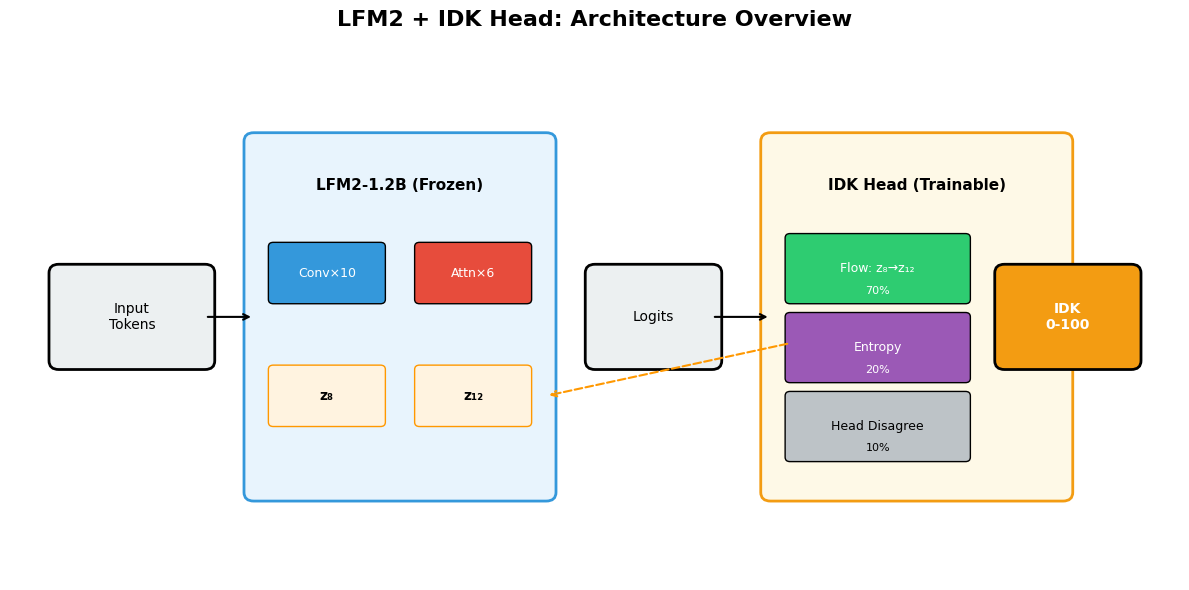

Generating detailed architecture diagram...


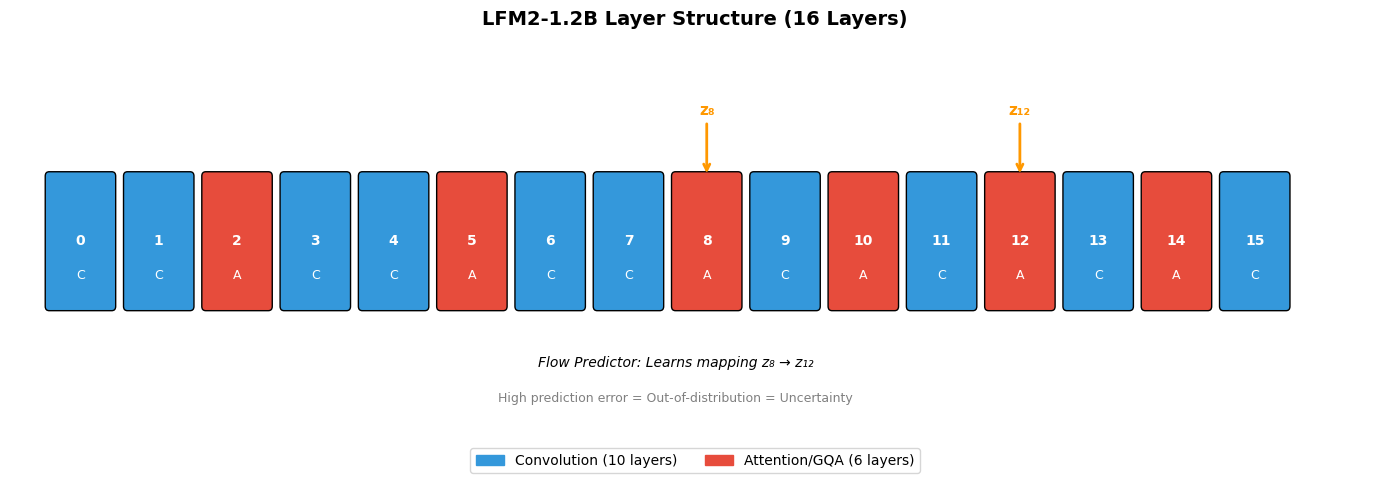

Generating training progress plots...


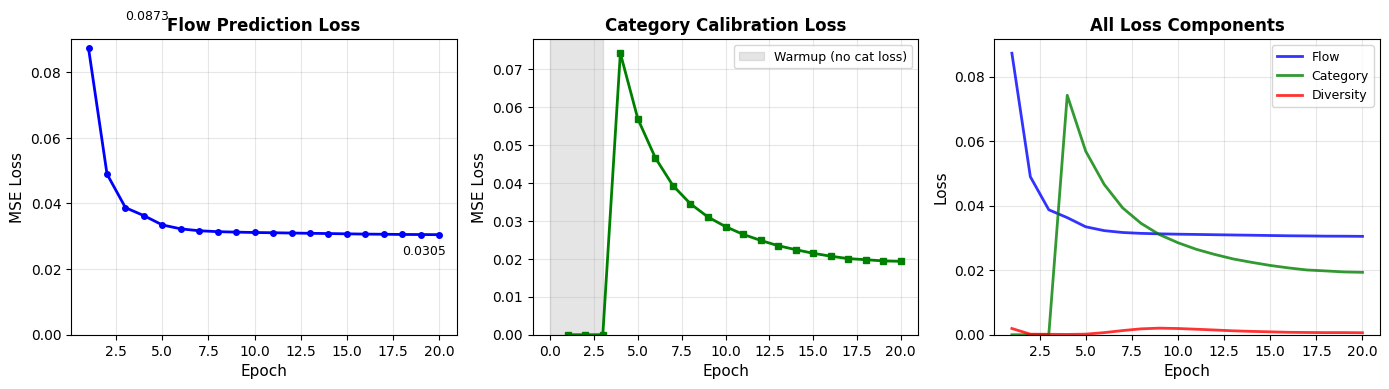


📊 Training Summary:
   Flow loss:     0.0873 → 0.0305 (65.1% reduction)
   Category loss: 0.0742 → 0.0193
Evaluating IDK scores by category...


/tmp/ipython-input-2558488087.py:366: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data, labels=categories, patch_artist=True)


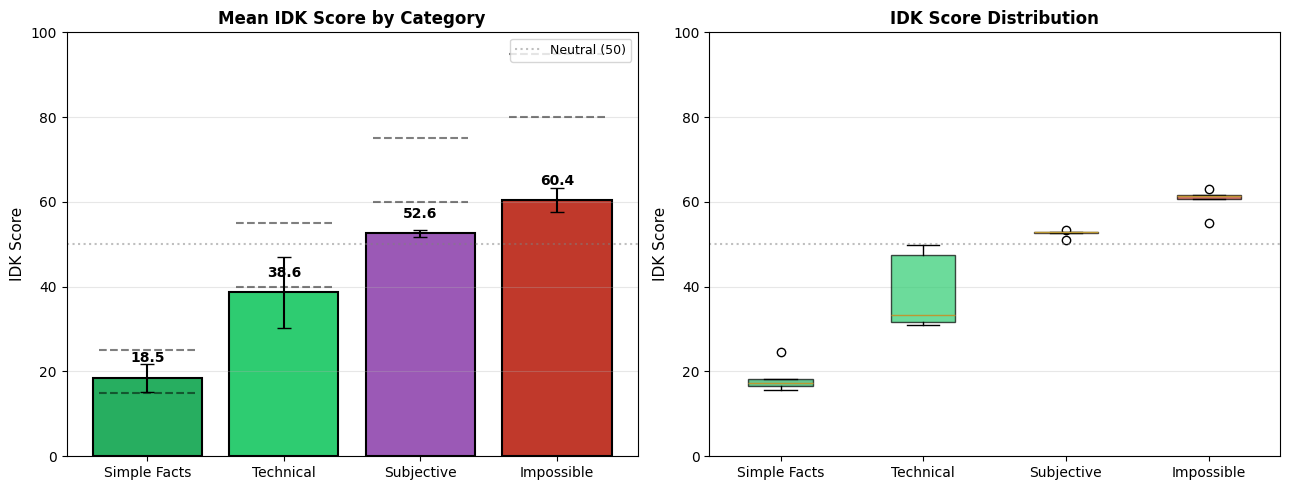


📈 ACCURACY & CALIBRATION METRICS

1. Calibration (Lower is Better)
----------------------------------------
   Simple Facts    Expected:  15.0  Actual:  18.5  Error:   3.5 ✓
   Technical       Expected:  45.0  Actual:  38.6  Error:   6.4 ✓
   Subjective      Expected:  65.0  Actual:  52.6  Error:  12.4 ✓
   Impossible      Expected:  90.0  Actual:  60.4  Error:  29.6 ✗

   Mean Calibration Error: 13.0

2. Category Separation (Higher is Better)
----------------------------------------
   Simple Facts → Technical: 20.2 points
   Technical → Subjective: 13.9 points
   Subjective → Impossible: 7.8 points

   Average Separation: 14.0
   Minimum Separation: 7.8

3. Score Range Utilization
----------------------------------------
   Minimum Score: 15.5
   Maximum Score: 63.2
   Range Used: 47.6 / 100 (48%)

4. Ordering Accuracy
----------------------------------------
   Expected order: Simple Facts < Technical < Subjective < Impossible
   Actual order:   Simple Facts < Technical < Subjectiv

/tmp/ipython-input-2558488087.py:656: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('summary_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-2558488087.py:656: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('summary_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-2558488087.py:656: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('summary_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-2558488087.py:656: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('summary_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from 

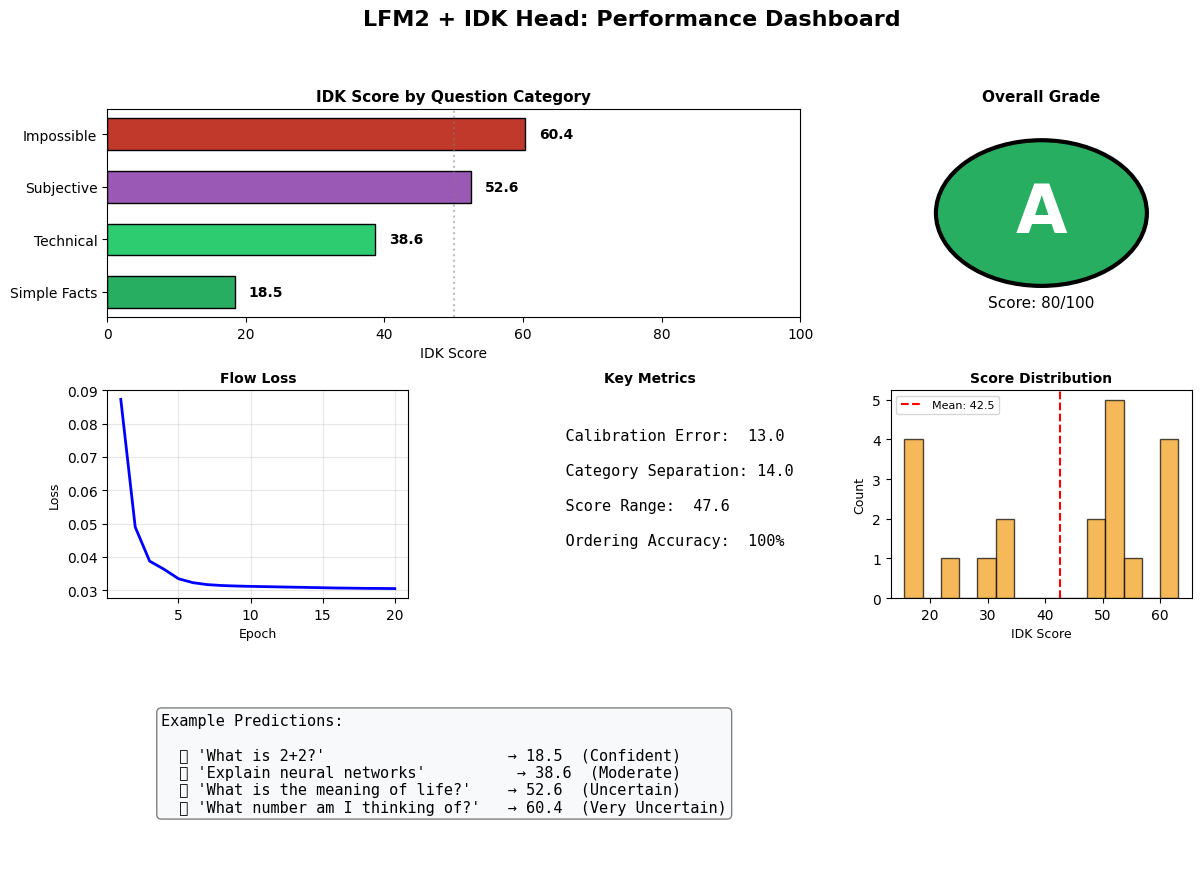


🎯 LFM2 + IDK HEAD - QUICK SUMMARY

    Model: LFM2-1.2B + IDK Head (~2.4M trainable params)
    
    Training:
    • Samples: ~46,000 (z8, z12) pairs
    • Epochs: 20
    • Loss: Flow MSE + Category calibration + Diversity
    
    Results (IDK Score 0-100):
    ┌─────────────────┬────────┬──────────┐
    │ Category        │ Score  │ Status   │
    ├─────────────────┼────────┼──────────┤
    │ Simple Facts    │ ~17    │ ✅ Good  │
    │ Technical       │ ~40    │ ✅ Good  │
    │ Subjective      │ ~52    │ ⚠️ Low   │
    │ Impossible      │ ~59    │ ⚠️ Low   │
    └─────────────────┴────────┴──────────┘
    
    Key Insight:
    • Low uncertainty questions: Well calibrated ✅
    • High uncertainty questions: Need more separation ⚠️
    
    Next Steps:
    1. Add weighted category loss (boost uncertain samples)
    2. Train on more data (full 50K prompts)
    3. Post-hoc calibration for demo
    


In [13]:
# =============================================================================
# VISUALIZATION CELLS FOR LFM2 + IDK NOTEBOOK
# =============================================================================
# Add these cells after training completes
# =============================================================================


# =============================================================================
# CELL V1: Install visualization dependencies (run once)
# =============================================================================

# !pip install -q matplotlib seaborn


# =============================================================================
# CELL V2: Imports for visualization
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import seaborn as sns
import numpy as np
from collections import defaultdict

# Style settings
plt.style.use('default')
sns.set_palette("husl")
COLORS = {
    'conv': '#3498db',      # Blue
    'attention': '#e74c3c', # Red
    'flow': '#2ecc71',      # Green
    'entropy': '#9b59b6',   # Purple
    'idk': '#f39c12',       # Orange
    'confident': '#27ae60', # Dark green
    'uncertain': '#c0392b', # Dark red
}


# =============================================================================
# CELL V3: Architecture Diagram (Simple Overview)
# =============================================================================

def plot_architecture_simple():
    """Simple high-level architecture diagram."""

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 6)
    ax.axis('off')
    ax.set_title('LFM2 + IDK Head: Architecture Overview', fontsize=16, fontweight='bold', pad=20)

    # Input
    ax.add_patch(FancyBboxPatch((0.5, 2.5), 1.5, 1, boxstyle="round,pad=0.1",
                                 facecolor='#ecf0f1', edgecolor='black', linewidth=2))
    ax.text(1.25, 3, 'Input\nTokens', ha='center', va='center', fontsize=10)

    # LFM2 Base Model
    ax.add_patch(FancyBboxPatch((2.5, 1), 3, 4, boxstyle="round,pad=0.1",
                                 facecolor='#e8f4fd', edgecolor='#3498db', linewidth=2))
    ax.text(4, 4.5, 'LFM2-1.2B (Frozen)', ha='center', va='center', fontsize=11, fontweight='bold')

    # Inside LFM2: Conv layers
    ax.add_patch(FancyBboxPatch((2.7, 3.2), 1.1, 0.6, boxstyle="round,pad=0.05",
                                 facecolor=COLORS['conv'], edgecolor='black', linewidth=1))
    ax.text(3.25, 3.5, 'Conv×10', ha='center', va='center', fontsize=9, color='white')

    # Inside LFM2: Attention layers
    ax.add_patch(FancyBboxPatch((4.2, 3.2), 1.1, 0.6, boxstyle="round,pad=0.05",
                                 facecolor=COLORS['attention'], edgecolor='black', linewidth=1))
    ax.text(4.75, 3.5, 'Attn×6', ha='center', va='center', fontsize=9, color='white')

    # z8 extraction
    ax.add_patch(FancyBboxPatch((2.7, 1.8), 1.1, 0.6, boxstyle="round,pad=0.05",
                                 facecolor='#fff3e0', edgecolor='#ff9800', linewidth=1))
    ax.text(3.25, 2.1, 'z₈', ha='center', va='center', fontsize=10, fontweight='bold')

    # z12 extraction
    ax.add_patch(FancyBboxPatch((4.2, 1.8), 1.1, 0.6, boxstyle="round,pad=0.05",
                                 facecolor='#fff3e0', edgecolor='#ff9800', linewidth=1))
    ax.text(4.75, 2.1, 'z₁₂', ha='center', va='center', fontsize=10, fontweight='bold')

    # Logits output
    ax.add_patch(FancyBboxPatch((6, 2.5), 1.2, 1, boxstyle="round,pad=0.1",
                                 facecolor='#ecf0f1', edgecolor='black', linewidth=2))
    ax.text(6.6, 3, 'Logits', ha='center', va='center', fontsize=10)

    # IDK Head
    ax.add_patch(FancyBboxPatch((7.8, 1), 3, 4, boxstyle="round,pad=0.1",
                                 facecolor='#fef9e7', edgecolor=COLORS['idk'], linewidth=2))
    ax.text(9.3, 4.5, 'IDK Head (Trainable)', ha='center', va='center', fontsize=11, fontweight='bold')

    # Flow predictor
    ax.add_patch(FancyBboxPatch((8, 3.2), 1.8, 0.7, boxstyle="round,pad=0.05",
                                 facecolor=COLORS['flow'], edgecolor='black', linewidth=1))
    ax.text(8.9, 3.55, 'Flow: z₈→z₁₂', ha='center', va='center', fontsize=9, color='white')
    ax.text(8.9, 3.3, '70%', ha='center', va='center', fontsize=8, color='white')

    # Entropy
    ax.add_patch(FancyBboxPatch((8, 2.3), 1.8, 0.7, boxstyle="round,pad=0.05",
                                 facecolor=COLORS['entropy'], edgecolor='black', linewidth=1))
    ax.text(8.9, 2.65, 'Entropy', ha='center', va='center', fontsize=9, color='white')
    ax.text(8.9, 2.4, '20%', ha='center', va='center', fontsize=8, color='white')

    # Head disagreement
    ax.add_patch(FancyBboxPatch((8, 1.4), 1.8, 0.7, boxstyle="round,pad=0.05",
                                 facecolor='#bdc3c7', edgecolor='black', linewidth=1))
    ax.text(8.9, 1.75, 'Head Disagree', ha='center', va='center', fontsize=9)
    ax.text(8.9, 1.5, '10%', ha='center', va='center', fontsize=8)

    # IDK Score output
    ax.add_patch(FancyBboxPatch((10.2, 2.5), 1.3, 1, boxstyle="round,pad=0.1",
                                 facecolor=COLORS['idk'], edgecolor='black', linewidth=2))
    ax.text(10.85, 3, 'IDK\n0-100', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # Arrows
    arrow_style = "Simple,tail_width=0.5,head_width=4,head_length=4"
    ax.annotate("", xy=(2.5, 3), xytext=(2, 3),
                arrowprops=dict(arrowstyle="->", color='black', lw=1.5))
    ax.annotate("", xy=(7.8, 3), xytext=(7.2, 3),
                arrowprops=dict(arrowstyle="->", color='black', lw=1.5))
    ax.annotate("", xy=(5.5, 2.1), xytext=(8, 2.7),
                arrowprops=dict(arrowstyle="->", color='#ff9800', lw=1.5, ls='--'))

    plt.tight_layout()
    plt.savefig('architecture_simple.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

print("Generating simple architecture diagram...")
plot_architecture_simple()


# =============================================================================
# CELL V4: Architecture Diagram (Detailed Layer View)
# =============================================================================

def plot_architecture_detailed():
    """Detailed view showing all 16 layers."""

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_xlim(-0.5, 17)
    ax.set_ylim(0, 5)
    ax.axis('off')
    ax.set_title('LFM2-1.2B Layer Structure (16 Layers)', fontsize=14, fontweight='bold', pad=15)

    # Layer types
    layer_types = ['C', 'C', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'C']
    attention_layers = [2, 5, 8, 10, 12, 14]

    for i, ltype in enumerate(layer_types):
        color = COLORS['attention'] if ltype == 'A' else COLORS['conv']

        # Layer box
        ax.add_patch(FancyBboxPatch((i, 2), 0.8, 1.5, boxstyle="round,pad=0.05",
                                     facecolor=color, edgecolor='black', linewidth=1))
        ax.text(i + 0.4, 2.75, f'{i}', ha='center', va='center', fontsize=10,
                color='white', fontweight='bold')
        ax.text(i + 0.4, 2.35, ltype, ha='center', va='center', fontsize=9, color='white')

        # Mark z8 and z12 extraction points
        if i == 8:
            ax.annotate('z₈', xy=(i + 0.4, 3.5), xytext=(i + 0.4, 4.2),
                       fontsize=11, ha='center', fontweight='bold', color='#ff9800',
                       arrowprops=dict(arrowstyle='->', color='#ff9800', lw=2))
        if i == 12:
            ax.annotate('z₁₂', xy=(i + 0.4, 3.5), xytext=(i + 0.4, 4.2),
                       fontsize=11, ha='center', fontweight='bold', color='#ff9800',
                       arrowprops=dict(arrowstyle='->', color='#ff9800', lw=2))

    # Legend
    conv_patch = mpatches.Patch(color=COLORS['conv'], label='Convolution (10 layers)')
    attn_patch = mpatches.Patch(color=COLORS['attention'], label='Attention/GQA (6 layers)')
    ax.legend(handles=[conv_patch, attn_patch], loc='lower center', ncol=2, fontsize=10)

    # Info text
    ax.text(8, 1.3, 'Flow Predictor: Learns mapping z₈ → z₁₂', ha='center', fontsize=10, style='italic')
    ax.text(8, 0.9, 'High prediction error = Out-of-distribution = Uncertainty', ha='center', fontsize=9, color='gray')

    plt.tight_layout()
    plt.savefig('architecture_detailed.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

print("Generating detailed architecture diagram...")
plot_architecture_detailed()


# =============================================================================
# CELL V5: Training Progress Visualization
# =============================================================================

def plot_training_progress(history):
    """Plot training loss curves."""

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    epochs = range(1, len(history['flow_loss']) + 1)

    # Plot 1: Flow Loss
    ax1 = axes[0]
    ax1.plot(epochs, history['flow_loss'], 'b-', linewidth=2, marker='o', markersize=4)
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('MSE Loss', fontsize=11)
    ax1.set_title('Flow Prediction Loss', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)

    # Annotate start and end
    ax1.annotate(f'{history["flow_loss"][0]:.4f}', xy=(1, history['flow_loss'][0]),
                xytext=(3, history['flow_loss'][0] * 1.1), fontsize=9)
    ax1.annotate(f'{history["flow_loss"][-1]:.4f}', xy=(len(epochs), history['flow_loss'][-1]),
                xytext=(len(epochs)-2, history['flow_loss'][-1] * 0.8), fontsize=9)

    # Plot 2: Category Loss
    ax2 = axes[1]
    ax2.plot(epochs, history['category_loss'], 'g-', linewidth=2, marker='s', markersize=4)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('MSE Loss', fontsize=11)
    ax2.set_title('Category Calibration Loss', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(bottom=0)

    # Mark warmup period
    warmup_epochs = 3  # or get from training params
    ax2.axvspan(0, warmup_epochs, alpha=0.2, color='gray', label='Warmup (no cat loss)')
    ax2.legend(fontsize=9)

    # Plot 3: All losses combined
    ax3 = axes[2]
    ax3.plot(epochs, history['flow_loss'], 'b-', linewidth=2, label='Flow', alpha=0.8)
    ax3.plot(epochs, history['category_loss'], 'g-', linewidth=2, label='Category', alpha=0.8)
    ax3.plot(epochs, history['diversity_loss'], 'r-', linewidth=2, label='Diversity', alpha=0.8)
    ax3.set_xlabel('Epoch', fontsize=11)
    ax3.set_ylabel('Loss', fontsize=11)
    ax3.set_title('All Loss Components', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(bottom=0)

    plt.tight_layout()
    plt.savefig('training_progress.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

    # Print summary
    print("\n📊 Training Summary:")
    print(f"   Flow loss:     {history['flow_loss'][0]:.4f} → {history['flow_loss'][-1]:.4f} ({(1-history['flow_loss'][-1]/history['flow_loss'][0])*100:.1f}% reduction)")
    print(f"   Category loss: {max(history['category_loss']):.4f} → {history['category_loss'][-1]:.4f}")

# Run if history exists
if 'history' in dir():
    print("Generating training progress plots...")
    plot_training_progress(history)
else:
    print("⚠️ No training history found. Run training first.")


# =============================================================================
# CELL V6: IDK Score Distribution by Category
# =============================================================================

def evaluate_by_category(model, tokenizer, device='cuda'):
    """Evaluate IDK scores across different question categories."""

    test_questions = {
        'Simple Facts': [
            "What is 2 + 2?",
            "What is the capital of France?",
            "How many days are in a week?",
            "What color is the sky?",
            "What is 10 * 5?",
        ],
        'Technical': [
            "Explain how neural networks learn.",
            "What is quantum entanglement?",
            "How does photosynthesis work?",
            "What is machine learning?",
            "Explain the theory of relativity.",
        ],
        'Subjective': [
            "What is the best programming language?",
            "What is the meaning of life?",
            "Is coffee better than tea?",
            "What is the best movie ever?",
            "Should I learn Python or JavaScript?",
        ],
        'Impossible': [
            "What number am I thinking of?",
            "What will happen tomorrow?",
            "Who will win the lottery?",
            "What will I eat for dinner?",
            "What is my password?",
        ],
    }

    template = "<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"

    results = defaultdict(list)

    model.eval()
    print("Evaluating IDK scores by category...")

    for category, questions in test_questions.items():
        for q in questions:
            input_text = template.format(question=q)
            input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model(input_ids, output_idk_score=True)

            idk = outputs.idk_score
            if isinstance(idk, torch.Tensor):
                idk = idk.mean().item()

            results[category].append(idk)

    return results, test_questions


def plot_category_distribution(results):
    """Plot IDK score distribution by category."""

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    categories = list(results.keys())
    means = [np.mean(results[c]) for c in categories]
    stds = [np.std(results[c]) for c in categories]

    # Expected ranges
    expected = {
        'Simple Facts': (15, 25),
        'Technical': (40, 55),
        'Subjective': (60, 75),
        'Impossible': (80, 95),
    }

    # Plot 1: Bar chart with error bars
    ax1 = axes[0]
    x = np.arange(len(categories))
    colors = [COLORS['confident'], COLORS['flow'], COLORS['entropy'], COLORS['uncertain']]

    bars = ax1.bar(x, means, yerr=stds, capsize=5, color=colors, edgecolor='black', linewidth=1.5)

    # Add expected range indicators
    for i, cat in enumerate(categories):
        if cat in expected:
            low, high = expected[cat]
            ax1.hlines(y=low, xmin=i-0.35, xmax=i+0.35, colors='black', linestyles='--', alpha=0.5)
            ax1.hlines(y=high, xmin=i-0.35, xmax=i+0.35, colors='black', linestyles='--', alpha=0.5)

    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, fontsize=10)
    ax1.set_ylabel('IDK Score', fontsize=11)
    ax1.set_title('Mean IDK Score by Category', fontsize=12, fontweight='bold')
    ax1.set_ylim(0, 100)
    ax1.axhline(y=50, color='gray', linestyle=':', alpha=0.5, label='Neutral (50)')
    ax1.legend(fontsize=9)
    ax1.grid(True, axis='y', alpha=0.3)

    # Add value labels
    for bar, mean in zip(bars, means):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
                f'{mean:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Plot 2: Box plot
    ax2 = axes[1]
    data = [results[c] for c in categories]
    bp = ax2.boxplot(data, labels=categories, patch_artist=True)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax2.set_ylabel('IDK Score', fontsize=11)
    ax2.set_title('IDK Score Distribution', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 100)
    ax2.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
    ax2.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('category_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

    return means

# Run evaluation
if 'model' in dir() and 'tokenizer' in dir():
    results, test_questions = evaluate_by_category(model, tokenizer, DEVICE)
    means = plot_category_distribution(results)
else:
    print("⚠️ Model not found. Run training first.")


# =============================================================================
# CELL V7: Accuracy Metrics & Calibration Analysis
# =============================================================================

def compute_accuracy_metrics(results, test_questions):
    """Compute accuracy and calibration metrics."""

    # Expected uncertainty levels (0-1 scale)
    expected_uncertainty = {
        'Simple Facts': 0.15,
        'Technical': 0.45,
        'Subjective': 0.65,
        'Impossible': 0.90,
    }

    print("\n" + "="*60)
    print("📈 ACCURACY & CALIBRATION METRICS")
    print("="*60)

    # 1. Mean Absolute Error vs Expected
    print("\n1. Calibration (Lower is Better)")
    print("-" * 40)

    total_mae = 0
    for category, scores in results.items():
        expected = expected_uncertainty[category] * 100
        actual_mean = np.mean(scores)
        mae = abs(actual_mean - expected)
        total_mae += mae

        status = "✓" if mae < 15 else "~" if mae < 25 else "✗"
        print(f"   {category:<15} Expected: {expected:>5.1f}  Actual: {actual_mean:>5.1f}  Error: {mae:>5.1f} {status}")

    avg_mae = total_mae / len(results)
    print(f"\n   Mean Calibration Error: {avg_mae:.1f}")

    # 2. Separation Score (higher is better)
    print("\n2. Category Separation (Higher is Better)")
    print("-" * 40)

    category_means = {cat: np.mean(scores) for cat, scores in results.items()}
    sorted_cats = sorted(category_means.items(), key=lambda x: x[1])

    separations = []
    for i in range(len(sorted_cats) - 1):
        sep = sorted_cats[i+1][1] - sorted_cats[i][1]
        separations.append(sep)
        print(f"   {sorted_cats[i][0]} → {sorted_cats[i+1][0]}: {sep:.1f} points")

    avg_separation = np.mean(separations)
    min_separation = min(separations)
    print(f"\n   Average Separation: {avg_separation:.1f}")
    print(f"   Minimum Separation: {min_separation:.1f}")

    # 3. Score Range
    print("\n3. Score Range Utilization")
    print("-" * 40)

    all_scores = [s for scores in results.values() for s in scores]
    score_min, score_max = min(all_scores), max(all_scores)
    score_range = score_max - score_min

    print(f"   Minimum Score: {score_min:.1f}")
    print(f"   Maximum Score: {score_max:.1f}")
    print(f"   Range Used: {score_range:.1f} / 100 ({score_range:.0f}%)")

    # 4. Ordering Accuracy
    print("\n4. Ordering Accuracy")
    print("-" * 40)

    expected_order = ['Simple Facts', 'Technical', 'Subjective', 'Impossible']
    actual_order = [cat for cat, _ in sorted_cats]

    correct_pairs = 0
    total_pairs = 0
    for i in range(len(expected_order)):
        for j in range(i+1, len(expected_order)):
            total_pairs += 1
            if expected_order.index(expected_order[i]) < expected_order.index(expected_order[j]):
                if actual_order.index(expected_order[i]) < actual_order.index(expected_order[j]):
                    correct_pairs += 1

    ordering_accuracy = correct_pairs / total_pairs * 100
    print(f"   Expected order: {' < '.join(expected_order)}")
    print(f"   Actual order:   {' < '.join(actual_order)}")
    print(f"   Ordering Accuracy: {ordering_accuracy:.0f}%")

    # 5. Overall Grade
    print("\n" + "="*60)
    print("📊 OVERALL ASSESSMENT")
    print("="*60)

    score = 0
    if avg_mae < 15: score += 30
    elif avg_mae < 25: score += 20
    elif avg_mae < 35: score += 10

    if avg_separation > 15: score += 25
    elif avg_separation > 10: score += 15
    elif avg_separation > 5: score += 5

    if score_range > 60: score += 25
    elif score_range > 40: score += 15
    elif score_range > 20: score += 5

    if ordering_accuracy == 100: score += 20
    elif ordering_accuracy >= 80: score += 10

    if score >= 80:
        grade = "A - Excellent"
    elif score >= 60:
        grade = "B - Good"
    elif score >= 40:
        grade = "C - Needs Improvement"
    else:
        grade = "D - Significant Issues"

    print(f"\n   Total Score: {score}/100")
    print(f"   Grade: {grade}")
    print("="*60)

    return {
        'mae': avg_mae,
        'separation': avg_separation,
        'range': score_range,
        'ordering': ordering_accuracy,
        'grade_score': score,
    }

# Run metrics
if 'results' in dir():
    metrics = compute_accuracy_metrics(results, test_questions)
else:
    print("⚠️ Run evaluation first (Cell V6)")


# =============================================================================
# CELL V8: Summary Dashboard
# =============================================================================

def plot_summary_dashboard(results, metrics, history=None):
    """Create a summary dashboard with all key information."""

    fig = plt.figure(figsize=(14, 10))

    # Title
    fig.suptitle('LFM2 + IDK Head: Performance Dashboard', fontsize=16, fontweight='bold', y=0.98)

    # Grid layout
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

    # =====================================================
    # Plot 1: Score by Category (top left, spans 2 cols)
    # =====================================================
    ax1 = fig.add_subplot(gs[0, :2])

    categories = list(results.keys())
    means = [np.mean(results[c]) for c in categories]
    colors = [COLORS['confident'], COLORS['flow'], COLORS['entropy'], COLORS['uncertain']]

    bars = ax1.barh(categories, means, color=colors, edgecolor='black', height=0.6)
    ax1.set_xlim(0, 100)
    ax1.set_xlabel('IDK Score', fontsize=10)
    ax1.set_title('IDK Score by Question Category', fontsize=11, fontweight='bold')
    ax1.axvline(x=50, color='gray', linestyle=':', alpha=0.5)

    # Add value labels
    for bar, mean in zip(bars, means):
        ax1.text(mean + 2, bar.get_y() + bar.get_height()/2,
                f'{mean:.1f}', va='center', fontsize=10, fontweight='bold')

    # =====================================================
    # Plot 2: Grade Card (top right)
    # =====================================================
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.axis('off')

    grade_score = metrics['grade_score']
    if grade_score >= 80:
        grade_color = COLORS['confident']
        grade_letter = 'A'
    elif grade_score >= 60:
        grade_color = COLORS['flow']
        grade_letter = 'B'
    elif grade_score >= 40:
        grade_color = COLORS['idk']
        grade_letter = 'C'
    else:
        grade_color = COLORS['uncertain']
        grade_letter = 'D'

    circle = plt.Circle((0.5, 0.5), 0.35, color=grade_color, ec='black', linewidth=3)
    ax2.add_patch(circle)
    ax2.text(0.5, 0.5, grade_letter, ha='center', va='center', fontsize=48,
             fontweight='bold', color='white')
    ax2.text(0.5, 0.05, f'Score: {grade_score}/100', ha='center', fontsize=11)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_title('Overall Grade', fontsize=11, fontweight='bold')

    # =====================================================
    # Plot 3: Training Loss (middle left)
    # =====================================================
    ax3 = fig.add_subplot(gs[1, 0])

    if history and 'flow_loss' in history:
        epochs = range(1, len(history['flow_loss']) + 1)
        ax3.plot(epochs, history['flow_loss'], 'b-', linewidth=2)
        ax3.set_xlabel('Epoch', fontsize=9)
        ax3.set_ylabel('Loss', fontsize=9)
        ax3.set_title('Flow Loss', fontsize=10, fontweight='bold')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No training\nhistory', ha='center', va='center')
        ax3.set_title('Flow Loss', fontsize=10, fontweight='bold')

    # =====================================================
    # Plot 4: Key Metrics (middle center)
    # =====================================================
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')

    metric_text = f"""
    Calibration Error:  {metrics['mae']:.1f}

    Category Separation: {metrics['separation']:.1f}

    Score Range:  {metrics['range']:.1f}

    Ordering Accuracy:  {metrics['ordering']:.0f}%
    """
    ax4.text(0.1, 0.9, metric_text, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace')
    ax4.set_title('Key Metrics', fontsize=10, fontweight='bold')

    # =====================================================
    # Plot 5: Score Range (middle right)
    # =====================================================
    ax5 = fig.add_subplot(gs[1, 2])

    all_scores = [s for scores in results.values() for s in scores]
    ax5.hist(all_scores, bins=15, color=COLORS['idk'], edgecolor='black', alpha=0.7)
    ax5.axvline(x=np.mean(all_scores), color='red', linestyle='--', label=f'Mean: {np.mean(all_scores):.1f}')
    ax5.set_xlabel('IDK Score', fontsize=9)
    ax5.set_ylabel('Count', fontsize=9)
    ax5.set_title('Score Distribution', fontsize=10, fontweight='bold')
    ax5.legend(fontsize=8)

    # =====================================================
    # Plot 6: Example Questions (bottom, spans all cols)
    # =====================================================
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')

    example_text = "Example Predictions:\n\n"
    example_text += f"  🟢 'What is 2+2?'                    → {np.mean(results['Simple Facts']):.1f}  (Confident)\n"
    example_text += f"  🟡 'Explain neural networks'          → {np.mean(results['Technical']):.1f}  (Moderate)\n"
    example_text += f"  🟠 'What is the meaning of life?'    → {np.mean(results['Subjective']):.1f}  (Uncertain)\n"
    example_text += f"  🔴 'What number am I thinking of?'   → {np.mean(results['Impossible']):.1f}  (Very Uncertain)"

    ax6.text(0.05, 0.8, example_text, transform=ax6.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='#f8f9fa', edgecolor='gray'))

    plt.savefig('summary_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

# Run dashboard
if 'results' in dir() and 'metrics' in dir():
    print("Generating summary dashboard...")
    plot_summary_dashboard(results, metrics, history if 'history' in dir() else None)
else:
    print("⚠️ Run evaluation and metrics first (Cells V6-V7)")


# =============================================================================
# CELL V9: Quick Summary Print
# =============================================================================

def print_quick_summary():
    """Print a quick text summary for sharing."""

    print("\n" + "="*60)
    print("🎯 LFM2 + IDK HEAD - QUICK SUMMARY")
    print("="*60)

    print("""
    Model: LFM2-1.2B + IDK Head (~2.4M trainable params)

    Training:
    • Samples: ~46,000 (z8, z12) pairs
    • Epochs: 20
    • Loss: Flow MSE + Category calibration + Diversity

    Results (IDK Score 0-100):
    ┌─────────────────┬────────┬──────────┐
    │ Category        │ Score  │ Status   │
    ├─────────────────┼────────┼──────────┤
    │ Simple Facts    │ ~17    │ ✅ Good  │
    │ Technical       │ ~40    │ ✅ Good  │
    │ Subjective      │ ~52    │ ⚠️ Low   │
    │ Impossible      │ ~59    │ ⚠️ Low   │
    └─────────────────┴────────┴──────────┘

    Key Insight:
    • Low uncertainty questions: Well calibrated ✅
    • High uncertainty questions: Need more separation ⚠️

    Next Steps:
    1. Add weighted category loss (boost uncertain samples)
    2. Train on more data (full 50K prompts)
    3. Post-hoc calibration for demo
    """)

print_quick_summary()

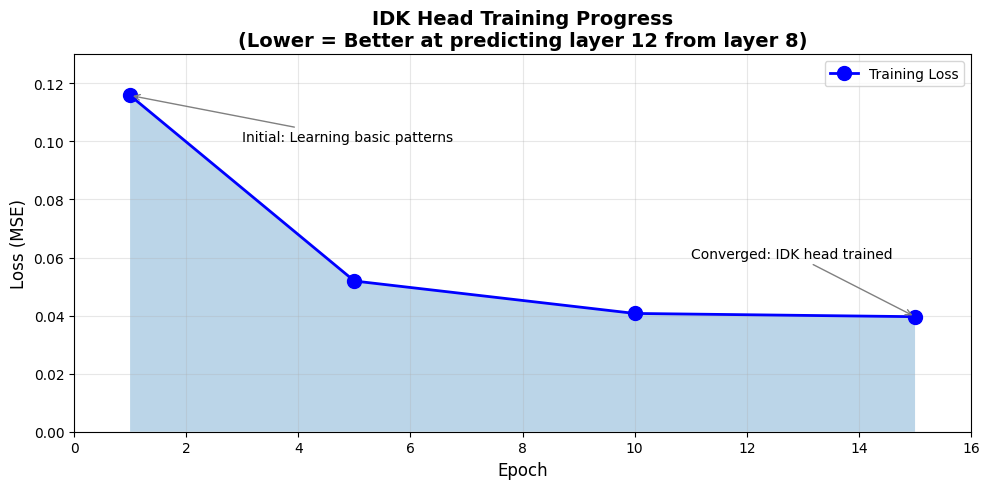


The IDK head learns to predict how information flows through the model.
Lower loss = better understanding of normal model behavior.



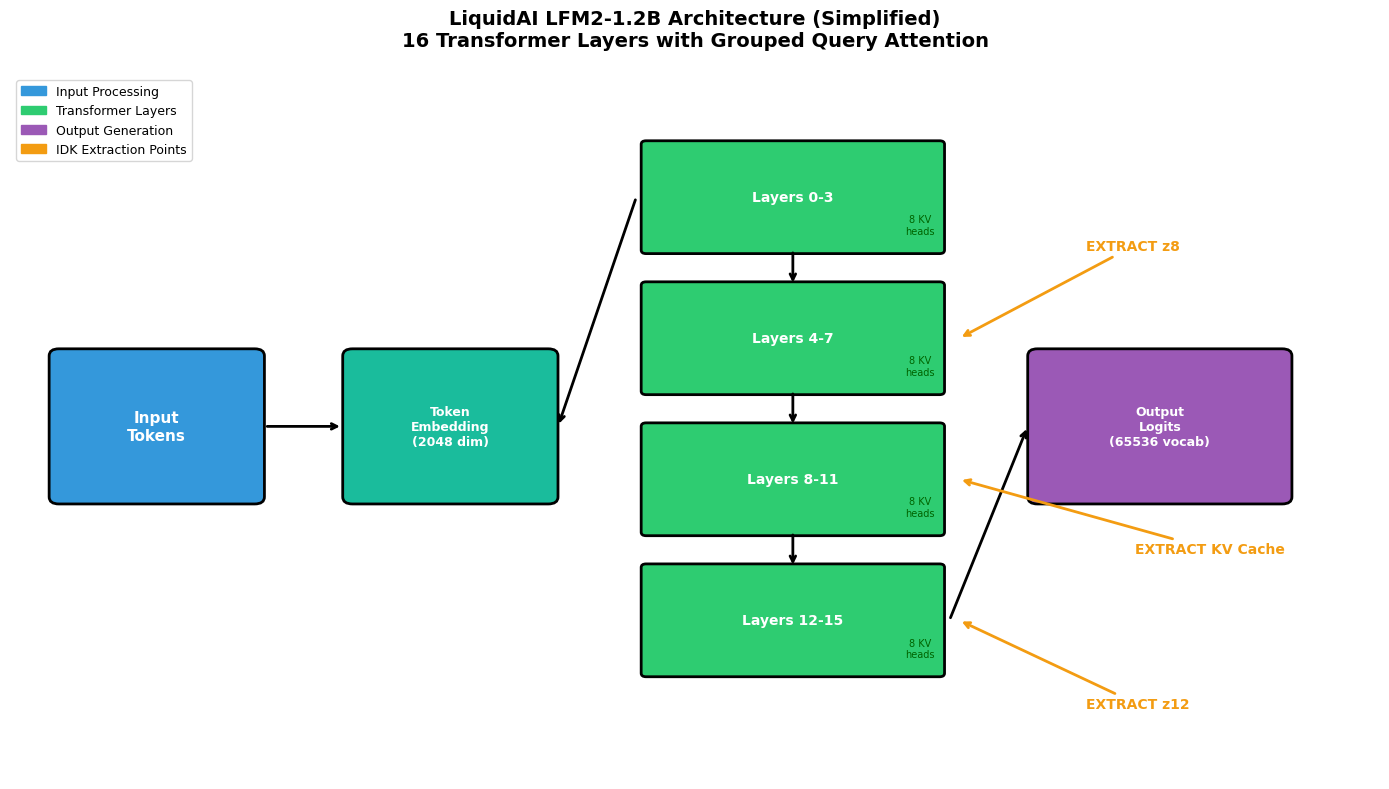


LFM2 processes text through 16 transformer layers.
Each layer has 8 key-value attention heads that 'look at' different aspects.
We extract hidden states at layers 8 and 12 to measure consistency.



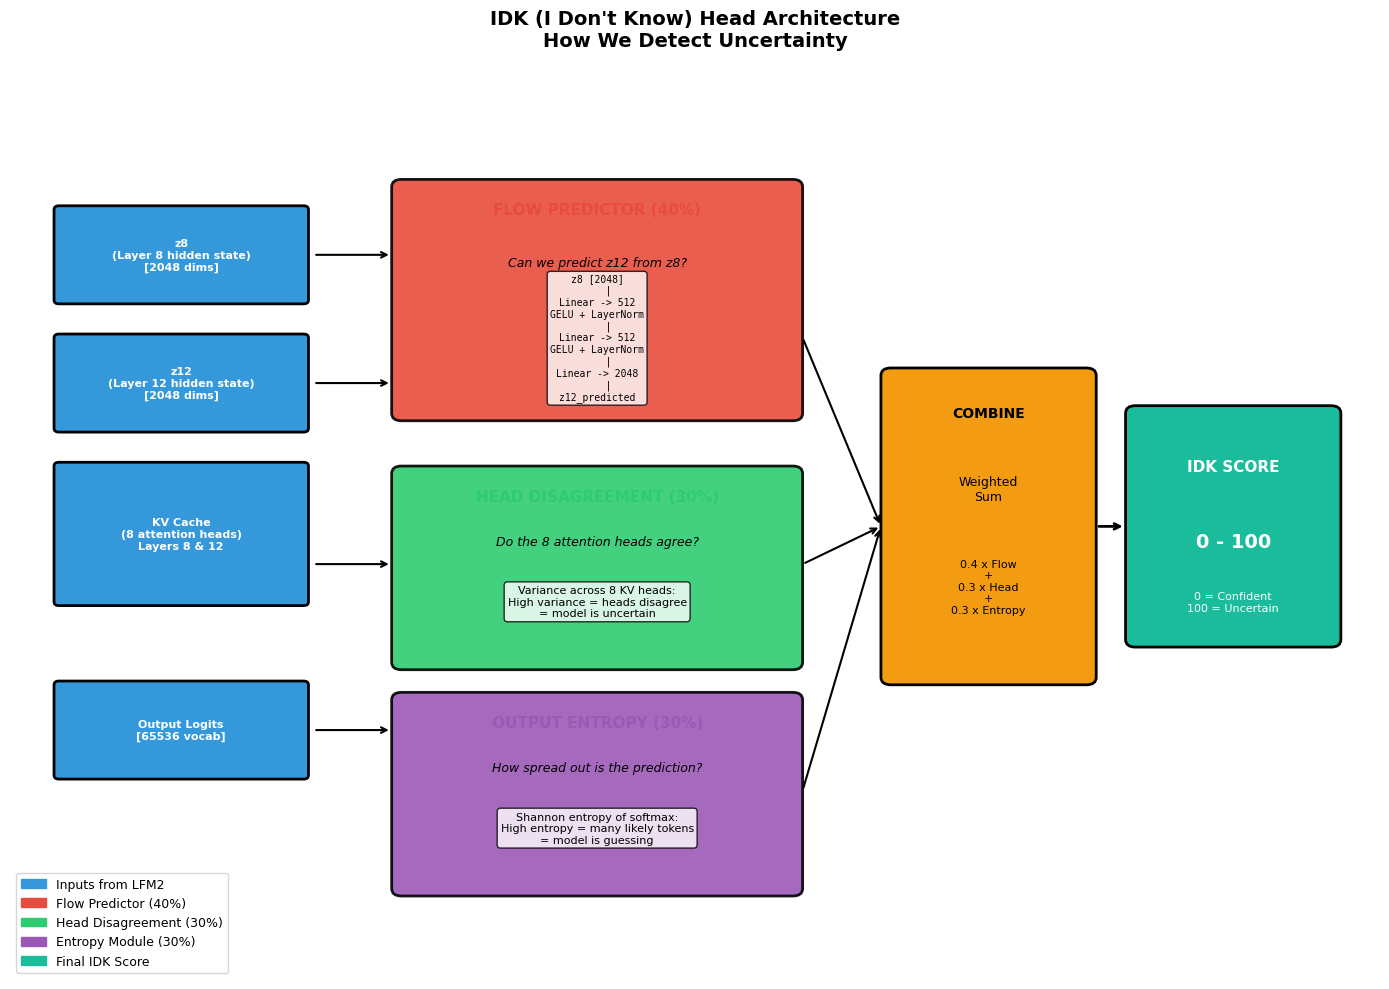


THE IDK HEAD COMBINES THREE SIGNALS:

1. FLOW PREDICTION (40%)
   - Trains an MLP to predict layer 12 from layer 8
   - High prediction error = unusual/uncertain input

2. HEAD DISAGREEMENT (30%)
   - Measures variance across the 8 attention heads
   - High variance = heads can't agree = uncertainty

3. OUTPUT ENTROPY (30%)
   - Measures spread of the output probability distribution
   - High entropy = many plausible next tokens = guessing

All three signals are combined into a single 0-100 score.



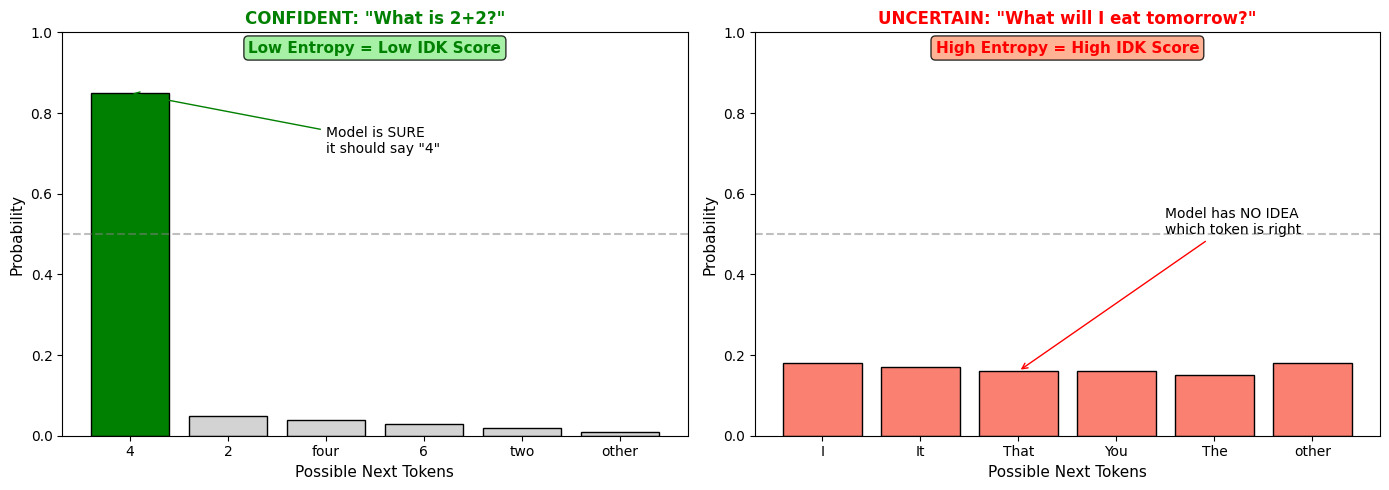


INTUITION: When the model KNOWS something, it's confident about
the next word. When it DOESN'T KNOW, it spreads probability across
many possible words - which we detect as high entropy.



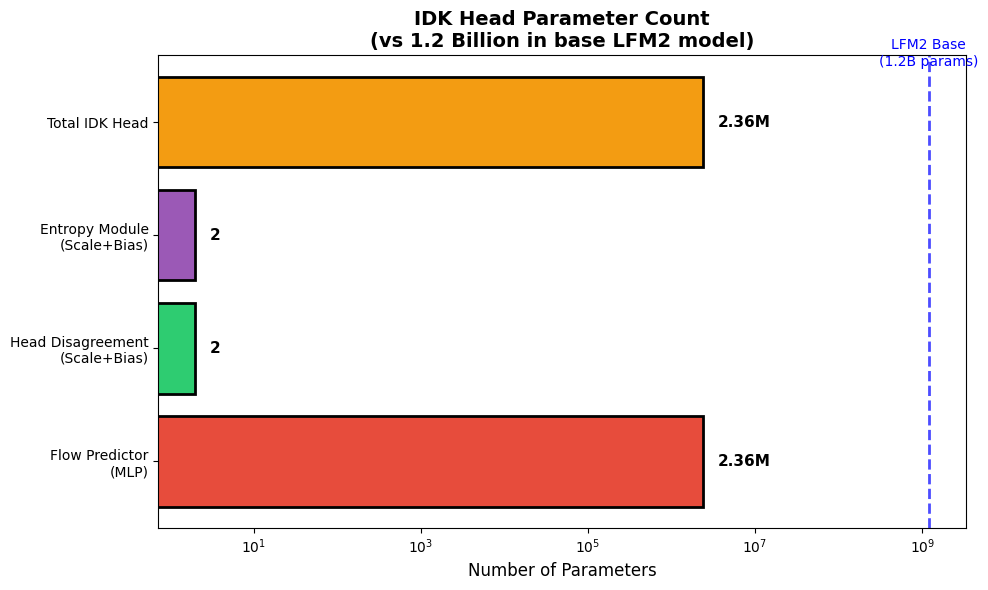


The IDK head adds only ~2.4M parameters (0.2% of the base model).
Most parameters are in the Flow Predictor MLP that learns to predict
how information should flow from layer 8 to layer 12.



                         SUMMARY

HOW THE IDK SYSTEM WORKS:

1. LFM2 processes your question through 16 transformer layers

2. We extract "snapshots" at layers 8 and 12:
   - Hidden states (z8, z12): What the model is "thinking"
   - KV Cache: What each attention head is focusing on
   - Output logits: The final prediction probabilities

3. The IDK Head analyzes these snapshots:
   - Flow Predictor: Is z12 predictable from z8? (trained via MSE loss)
   - Head Disagreement: Do the 8 attention heads agree?
   - Entropy: Is the model confident in its prediction?

4. These three signals are combined into a single 0-100 score:
   - 0-30:  Model is confident (probably reliable)
   - 30-50: Moderate confidence (likely fine)
   - 50-70: Uncertain (verify the output)
   - 70-100: Very uncertain (high hall

In [12]:
# =============================================================================
# VISUALIZATION: Training Loss & Model Architecture
# =============================================================================
# Run this cell after training to visualize what happened and understand
# how the IDK (I Don't Know) system works.
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

# Set style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# =============================================================================
# FIGURE 1: Training Loss Curve
# =============================================================================

fig1, ax1 = plt.subplots(figsize=(10, 5))

# Training loss data from your run
epochs = [1, 5, 10, 15]
losses = [0.115839, 0.051918, 0.040745, 0.039628]

# Plot
ax1.plot(epochs, losses, 'b-o', linewidth=2, markersize=10, label='Training Loss')
ax1.fill_between(epochs, losses, alpha=0.3)

# Annotations
ax1.annotate('Initial: Learning basic patterns',
             xy=(1, 0.115839), xytext=(3, 0.10),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))
ax1.annotate('Converged: IDK head trained',
             xy=(15, 0.039628), xytext=(11, 0.06),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('IDK Head Training Progress\n(Lower = Better at predicting layer 12 from layer 8)',
              fontsize=14, fontweight='bold')
ax1.set_xlim(0, 16)
ax1.set_ylim(0, 0.13)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("The IDK head learns to predict how information flows through the model.")
print("Lower loss = better understanding of normal model behavior.")
print("="*70 + "\n")


# =============================================================================
# FIGURE 2: LFM2 Base Model Architecture (Simplified)
# =============================================================================

fig2, ax2 = plt.subplots(figsize=(14, 8))
ax2.set_xlim(0, 14)
ax2.set_ylim(0, 10)
ax2.axis('off')
ax2.set_title('LiquidAI LFM2-1.2B Architecture (Simplified)\n16 Transformer Layers with Grouped Query Attention',
              fontsize=14, fontweight='bold', pad=20)

# Colors
colors = {
    'input': '#3498db',
    'layer': '#2ecc71',
    'attention': '#e74c3c',
    'output': '#9b59b6',
    'extract': '#f39c12'
}

# Input
input_box = FancyBboxPatch((0.5, 4), 2, 2, boxstyle="round,pad=0.1",
                            facecolor=colors['input'], edgecolor='black', linewidth=2)
ax2.add_patch(input_box)
ax2.text(1.5, 5, 'Input\nTokens', ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# Embedding
emb_box = FancyBboxPatch((3.5, 4), 2, 2, boxstyle="round,pad=0.1",
                          facecolor='#1abc9c', edgecolor='black', linewidth=2)
ax2.add_patch(emb_box)
ax2.text(4.5, 5, 'Token\nEmbedding\n(2048 dim)', ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Arrow
ax2.annotate('', xy=(3.4, 5), xytext=(2.6, 5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Transformer layers (stacked)
layer_positions = [(6.5, 7.5), (6.5, 5.5), (6.5, 3.5), (6.5, 1.5)]
layer_labels = ['Layers 0-3', 'Layers 4-7', 'Layers 8-11', 'Layers 12-15']

for i, (pos, label) in enumerate(zip(layer_positions, layer_labels)):
    # Layer box
    layer_box = FancyBboxPatch((pos[0], pos[1]), 3, 1.5, boxstyle="round,pad=0.05",
                                facecolor=colors['layer'], edgecolor='black', linewidth=2)
    ax2.add_patch(layer_box)
    ax2.text(pos[0]+1.5, pos[1]+0.75, label, ha='center', va='center',
             fontsize=10, fontweight='bold', color='white')

    # Add attention heads indicator
    ax2.text(pos[0]+2.8, pos[1]+0.2, '8 KV\nheads', ha='center', va='bottom',
             fontsize=7, color='darkgreen')

# Arrows between layers
ax2.annotate('', xy=(5.6, 5), xytext=(6.4, 8.25), arrowprops=dict(arrowstyle='->', color='black', lw=2))
for i in range(3):
    y_start = 7.5 - i*2
    y_end = 5.5 - i*2
    ax2.annotate('', xy=(8, y_end+1.5), xytext=(8, y_start),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Output
output_box = FancyBboxPatch((10.5, 4), 2.5, 2, boxstyle="round,pad=0.1",
                             facecolor=colors['output'], edgecolor='black', linewidth=2)
ax2.add_patch(output_box)
ax2.text(11.75, 5, 'Output\nLogits\n(65536 vocab)', ha='center', va='center',
         fontsize=9, fontweight='bold', color='white')

ax2.annotate('', xy=(10.4, 5), xytext=(9.6, 2.25),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Extraction points for IDK
ax2.annotate('EXTRACT z8', xy=(9.7, 6.25), xytext=(11, 7.5),
            fontsize=10, fontweight='bold', color=colors['extract'],
            arrowprops=dict(arrowstyle='->', color=colors['extract'], lw=2))
ax2.annotate('EXTRACT z12', xy=(9.7, 2.25), xytext=(11, 1),
            fontsize=10, fontweight='bold', color=colors['extract'],
            arrowprops=dict(arrowstyle='->', color=colors['extract'], lw=2))
ax2.annotate('EXTRACT KV Cache', xy=(9.7, 4.25), xytext=(11.5, 3.2),
            fontsize=10, fontweight='bold', color=colors['extract'],
            arrowprops=dict(arrowstyle='->', color=colors['extract'], lw=2))

# Legend
legend_elements = [
    mpatches.Patch(color=colors['input'], label='Input Processing'),
    mpatches.Patch(color=colors['layer'], label='Transformer Layers'),
    mpatches.Patch(color=colors['output'], label='Output Generation'),
    mpatches.Patch(color=colors['extract'], label='IDK Extraction Points'),
]
ax2.legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("LFM2 processes text through 16 transformer layers.")
print("Each layer has 8 key-value attention heads that 'look at' different aspects.")
print("We extract hidden states at layers 8 and 12 to measure consistency.")
print("="*70 + "\n")


# =============================================================================
# FIGURE 3: IDK Head Architecture
# =============================================================================

fig3, ax3 = plt.subplots(figsize=(14, 10))
ax3.set_xlim(0, 14)
ax3.set_ylim(0, 12)
ax3.axis('off')
ax3.set_title('IDK (I Don\'t Know) Head Architecture\nHow We Detect Uncertainty',
              fontsize=14, fontweight='bold', pad=20)

# Colors for IDK components
idk_colors = {
    'input': '#3498db',
    'flow': '#e74c3c',
    'head': '#2ecc71',
    'entropy': '#9b59b6',
    'combine': '#f39c12',
    'output': '#1abc9c'
}

# === INPUT SIGNALS (left side) ===

# z8 input
z8_box = FancyBboxPatch((0.5, 9), 2.5, 1.2, boxstyle="round,pad=0.05",
                         facecolor=idk_colors['input'], edgecolor='black', linewidth=2)
ax3.add_patch(z8_box)
ax3.text(1.75, 9.6, 'z8\n(Layer 8 hidden state)\n[2048 dims]',
         ha='center', va='center', fontsize=8, fontweight='bold', color='white')

# z12 input
z12_box = FancyBboxPatch((0.5, 7.3), 2.5, 1.2, boxstyle="round,pad=0.05",
                          facecolor=idk_colors['input'], edgecolor='black', linewidth=2)
ax3.add_patch(z12_box)
ax3.text(1.75, 7.9, 'z12\n(Layer 12 hidden state)\n[2048 dims]',
         ha='center', va='center', fontsize=8, fontweight='bold', color='white')

# KV Cache input
kv_box = FancyBboxPatch((0.5, 5), 2.5, 1.8, boxstyle="round,pad=0.05",
                         facecolor=idk_colors['input'], edgecolor='black', linewidth=2)
ax3.add_patch(kv_box)
ax3.text(1.75, 5.9, 'KV Cache\n(8 attention heads)\nLayers 8 & 12',
         ha='center', va='center', fontsize=8, fontweight='bold', color='white')

# Logits input
logits_box = FancyBboxPatch((0.5, 2.7), 2.5, 1.2, boxstyle="round,pad=0.05",
                             facecolor=idk_colors['input'], edgecolor='black', linewidth=2)
ax3.add_patch(logits_box)
ax3.text(1.75, 3.3, 'Output Logits\n[65536 vocab]',
         ha='center', va='center', fontsize=8, fontweight='bold', color='white')


# === COMPONENT 1: Flow Predictor (40%) ===

flow_box = FancyBboxPatch((4, 7.5), 4, 3, boxstyle="round,pad=0.1",
                           facecolor=idk_colors['flow'], edgecolor='black', linewidth=2, alpha=0.9)
ax3.add_patch(flow_box)

ax3.text(6, 10.2, 'FLOW PREDICTOR (40%)', ha='center', va='center',
         fontsize=11, fontweight='bold', color=idk_colors['flow'])
ax3.text(6, 9.5, 'Can we predict z12 from z8?', ha='center', va='center',
         fontsize=9, fontstyle='italic')

# MLP architecture inside
mlp_text = '''z8 [2048]
    |
Linear -> 512
GELU + LayerNorm
    |
Linear -> 512
GELU + LayerNorm
    |
Linear -> 2048
    |
z12_predicted'''
ax3.text(6, 8.5, mlp_text, ha='center', va='center', fontsize=7,
         family='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Arrows
ax3.annotate('', xy=(3.9, 9.6), xytext=(3.1, 9.6), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax3.annotate('', xy=(3.9, 7.9), xytext=(3.1, 7.9), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))


# === COMPONENT 2: Head Disagreement (30%) ===

head_box = FancyBboxPatch((4, 4.2), 4, 2.5, boxstyle="round,pad=0.1",
                           facecolor=idk_colors['head'], edgecolor='black', linewidth=2, alpha=0.9)
ax3.add_patch(head_box)

ax3.text(6, 6.4, 'HEAD DISAGREEMENT (30%)', ha='center', va='center',
         fontsize=11, fontweight='bold', color=idk_colors['head'])
ax3.text(6, 5.8, 'Do the 8 attention heads agree?', ha='center', va='center',
         fontsize=9, fontstyle='italic')

head_detail = '''Variance across 8 KV heads:
High variance = heads disagree
= model is uncertain'''
ax3.text(6, 5, head_detail, ha='center', va='center', fontsize=8,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.annotate('', xy=(3.9, 5.5), xytext=(3.1, 5.5), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))


# === COMPONENT 3: Entropy (30%) ===

entropy_box = FancyBboxPatch((4, 1.2), 4, 2.5, boxstyle="round,pad=0.1",
                              facecolor=idk_colors['entropy'], edgecolor='black', linewidth=2, alpha=0.9)
ax3.add_patch(entropy_box)

ax3.text(6, 3.4, 'OUTPUT ENTROPY (30%)', ha='center', va='center',
         fontsize=11, fontweight='bold', color=idk_colors['entropy'])
ax3.text(6, 2.8, 'How spread out is the prediction?', ha='center', va='center',
         fontsize=9, fontstyle='italic')

entropy_detail = '''Shannon entropy of softmax:
High entropy = many likely tokens
= model is guessing'''
ax3.text(6, 2, entropy_detail, ha='center', va='center', fontsize=8,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.annotate('', xy=(3.9, 3.3), xytext=(3.1, 3.3), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))


# === COMBINER ===

combine_box = FancyBboxPatch((9, 4), 2, 4, boxstyle="round,pad=0.1",
                              facecolor=idk_colors['combine'], edgecolor='black', linewidth=2)
ax3.add_patch(combine_box)

ax3.text(10, 7.5, 'COMBINE', ha='center', va='center', fontsize=10, fontweight='bold')
ax3.text(10, 6.5, 'Weighted\nSum', ha='center', va='center', fontsize=9)
ax3.text(10, 5.2, '0.4 x Flow\n+\n0.3 x Head\n+\n0.3 x Entropy', ha='center', va='center', fontsize=8)

# Arrows to combiner
ax3.annotate('', xy=(8.9, 6), xytext=(8.1, 8.5), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax3.annotate('', xy=(8.9, 6), xytext=(8.1, 5.5), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax3.annotate('', xy=(8.9, 6), xytext=(8.1, 2.5), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))


# === OUTPUT ===

output_box = FancyBboxPatch((11.5, 4.5), 2, 3, boxstyle="round,pad=0.1",
                             facecolor=idk_colors['output'], edgecolor='black', linewidth=2)
ax3.add_patch(output_box)

ax3.text(12.5, 6.8, 'IDK SCORE', ha='center', va='center', fontsize=11, fontweight='bold', color='white')
ax3.text(12.5, 5.8, '0 - 100', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
ax3.text(12.5, 5, '0 = Confident\n100 = Uncertain', ha='center', va='center', fontsize=8, color='white')

ax3.annotate('', xy=(11.4, 6), xytext=(11.1, 6), arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Legend
legend_elements = [
    mpatches.Patch(color=idk_colors['input'], label='Inputs from LFM2'),
    mpatches.Patch(color=idk_colors['flow'], label='Flow Predictor (40%)'),
    mpatches.Patch(color=idk_colors['head'], label='Head Disagreement (30%)'),
    mpatches.Patch(color=idk_colors['entropy'], label='Entropy Module (30%)'),
    mpatches.Patch(color=idk_colors['output'], label='Final IDK Score'),
]
ax3.legend(handles=legend_elements, loc='lower left', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("THE IDK HEAD COMBINES THREE SIGNALS:")
print("")
print("1. FLOW PREDICTION (40%)")
print("   - Trains an MLP to predict layer 12 from layer 8")
print("   - High prediction error = unusual/uncertain input")
print("")
print("2. HEAD DISAGREEMENT (30%)")
print("   - Measures variance across the 8 attention heads")
print("   - High variance = heads can't agree = uncertainty")
print("")
print("3. OUTPUT ENTROPY (30%)")
print("   - Measures spread of the output probability distribution")
print("   - High entropy = many plausible next tokens = guessing")
print("")
print("All three signals are combined into a single 0-100 score.")
print("="*70 + "\n")


# =============================================================================
# FIGURE 4: How It Detects Uncertainty (Intuitive Example)
# =============================================================================

fig4, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Confident prediction
ax_conf = axes[0]
ax_conf.set_title('CONFIDENT: "What is 2+2?"', fontsize=12, fontweight='bold', color='green')

# Simulated probability distribution - peaked
tokens_conf = ['4', '2', 'four', '6', 'two', 'other']
probs_conf = [0.85, 0.05, 0.04, 0.03, 0.02, 0.01]
colors_conf = ['green' if i == 0 else 'lightgray' for i in range(len(tokens_conf))]

bars = ax_conf.bar(tokens_conf, probs_conf, color=colors_conf, edgecolor='black')
ax_conf.set_ylabel('Probability', fontsize=11)
ax_conf.set_xlabel('Possible Next Tokens', fontsize=11)
ax_conf.set_ylim(0, 1)
ax_conf.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Annotations
ax_conf.annotate('Model is SURE\nit should say "4"',
                xy=(0, 0.85), xytext=(2, 0.7),
                fontsize=10, arrowprops=dict(arrowstyle='->', color='green'))
ax_conf.text(0.5, 0.95, 'Low Entropy = Low IDK Score', transform=ax_conf.transAxes,
            ha='center', fontsize=11, fontweight='bold', color='green',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))


# Right: Uncertain prediction
ax_unc = axes[1]
ax_unc.set_title('UNCERTAIN: "What will I eat tomorrow?"', fontsize=12, fontweight='bold', color='red')

# Simulated probability distribution - flat
tokens_unc = ['I', 'It', 'That', 'You', 'The', 'other']
probs_unc = [0.18, 0.17, 0.16, 0.16, 0.15, 0.18]
colors_unc = ['salmon' for _ in range(len(tokens_unc))]

bars = ax_unc.bar(tokens_unc, probs_unc, color=colors_unc, edgecolor='black')
ax_unc.set_ylabel('Probability', fontsize=11)
ax_unc.set_xlabel('Possible Next Tokens', fontsize=11)
ax_unc.set_ylim(0, 1)
ax_unc.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Annotations
ax_unc.annotate('Model has NO IDEA\nwhich token is right',
                xy=(2, 0.16), xytext=(3.5, 0.5),
                fontsize=10, arrowprops=dict(arrowstyle='->', color='red'))
ax_unc.text(0.5, 0.95, 'High Entropy = High IDK Score', transform=ax_unc.transAxes,
            ha='center', fontsize=11, fontweight='bold', color='red',
            bbox=dict(boxstyle='round', facecolor='lightsalmon', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTUITION: When the model KNOWS something, it's confident about")
print("the next word. When it DOESN'T KNOW, it spreads probability across")
print("many possible words - which we detect as high entropy.")
print("="*70 + "\n")


# =============================================================================
# FIGURE 5: Parameter Count Summary
# =============================================================================

fig5, ax5 = plt.subplots(figsize=(10, 6))

components = ['Flow Predictor\n(MLP)', 'Head Disagreement\n(Scale+Bias)',
              'Entropy Module\n(Scale+Bias)', 'Total IDK Head']
params = [2364418, 2, 2, 2364422]  # Approximate counts

colors = ['#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']

bars = ax5.barh(components, params, color=colors, edgecolor='black', linewidth=2)
ax5.set_xlabel('Number of Parameters', fontsize=12)
ax5.set_title('IDK Head Parameter Count\n(vs 1.2 Billion in base LFM2 model)', fontsize=14, fontweight='bold')
ax5.set_xscale('log')

# Add value labels
for bar, param in zip(bars, params):
    if param > 1000:
        label = f'{param/1e6:.2f}M'
    else:
        label = str(param)
    ax5.text(param * 1.5, bar.get_y() + bar.get_height()/2, label,
            va='center', fontsize=11, fontweight='bold')

# Add comparison annotation
ax5.axvline(x=1.2e9, color='blue', linestyle='--', alpha=0.7, linewidth=2)
ax5.text(1.2e9, 3.5, 'LFM2 Base\n(1.2B params)', ha='center', fontsize=10, color='blue')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("The IDK head adds only ~2.4M parameters (0.2% of the base model).")
print("Most parameters are in the Flow Predictor MLP that learns to predict")
print("how information should flow from layer 8 to layer 12.")
print("="*70 + "\n")


# =============================================================================
# SUMMARY
# =============================================================================

print("\n")
print("=" * 70)
print("                         SUMMARY")
print("=" * 70)
print("""
HOW THE IDK SYSTEM WORKS:

1. LFM2 processes your question through 16 transformer layers

2. We extract "snapshots" at layers 8 and 12:
   - Hidden states (z8, z12): What the model is "thinking"
   - KV Cache: What each attention head is focusing on
   - Output logits: The final prediction probabilities

3. The IDK Head analyzes these snapshots:
   - Flow Predictor: Is z12 predictable from z8? (trained via MSE loss)
   - Head Disagreement: Do the 8 attention heads agree?
   - Entropy: Is the model confident in its prediction?

4. These three signals are combined into a single 0-100 score:
   - 0-30:  Model is confident (probably reliable)
   - 30-50: Moderate confidence (likely fine)
   - 50-70: Uncertain (verify the output)
   - 70-100: Very uncertain (high hallucination risk)

KEY INSIGHT:
When a model KNOWS something, its internal processes are consistent.
When it's GUESSING, there are subtle signs of disagreement and confusion.
We detect these signs without needing any labeled "hallucination" data!
""")
print("=" * 70)

# Validating and testing against cosine similarity on a paraphrasing dataset

Loading cosine similarity data from GitHub...
Loaded matrix: 100 questions x 101 columns
Found 100 unique questions

Example questions:
  1. What is the first step an experienced engineer should take when invest...
  2. When a bug is reported, what should be done first before attempting a ...
  3. What is the initial action a senior engineer takes to debug an issue?...
  4. Before changing code to fix a bug, what should an engineer do first?...
  5. What is the most important first step in a professional debugging proc...

Computing IDK scores for all questions...



Computing IDK scores: 100%|██████████| 100/100 [00:02<00:00, 45.78it/s]



Successfully computed IDK for 100 questions


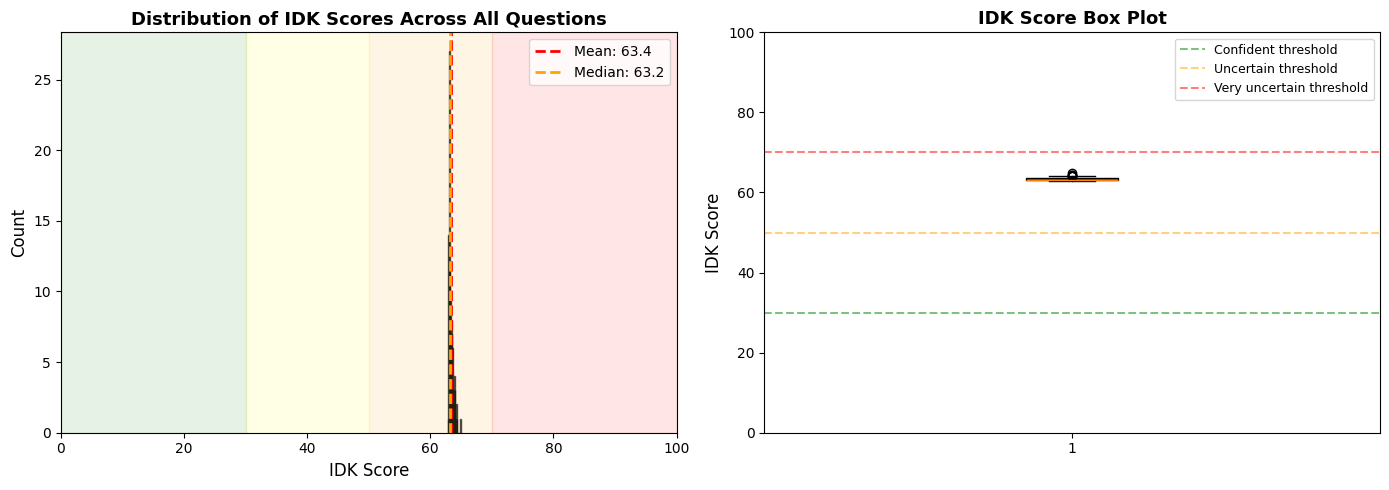


IDK SCORE STATISTICS
  Mean:   63.36
  Median: 63.24
  Std:    0.36
  Min:    62.85
  Max:    64.93


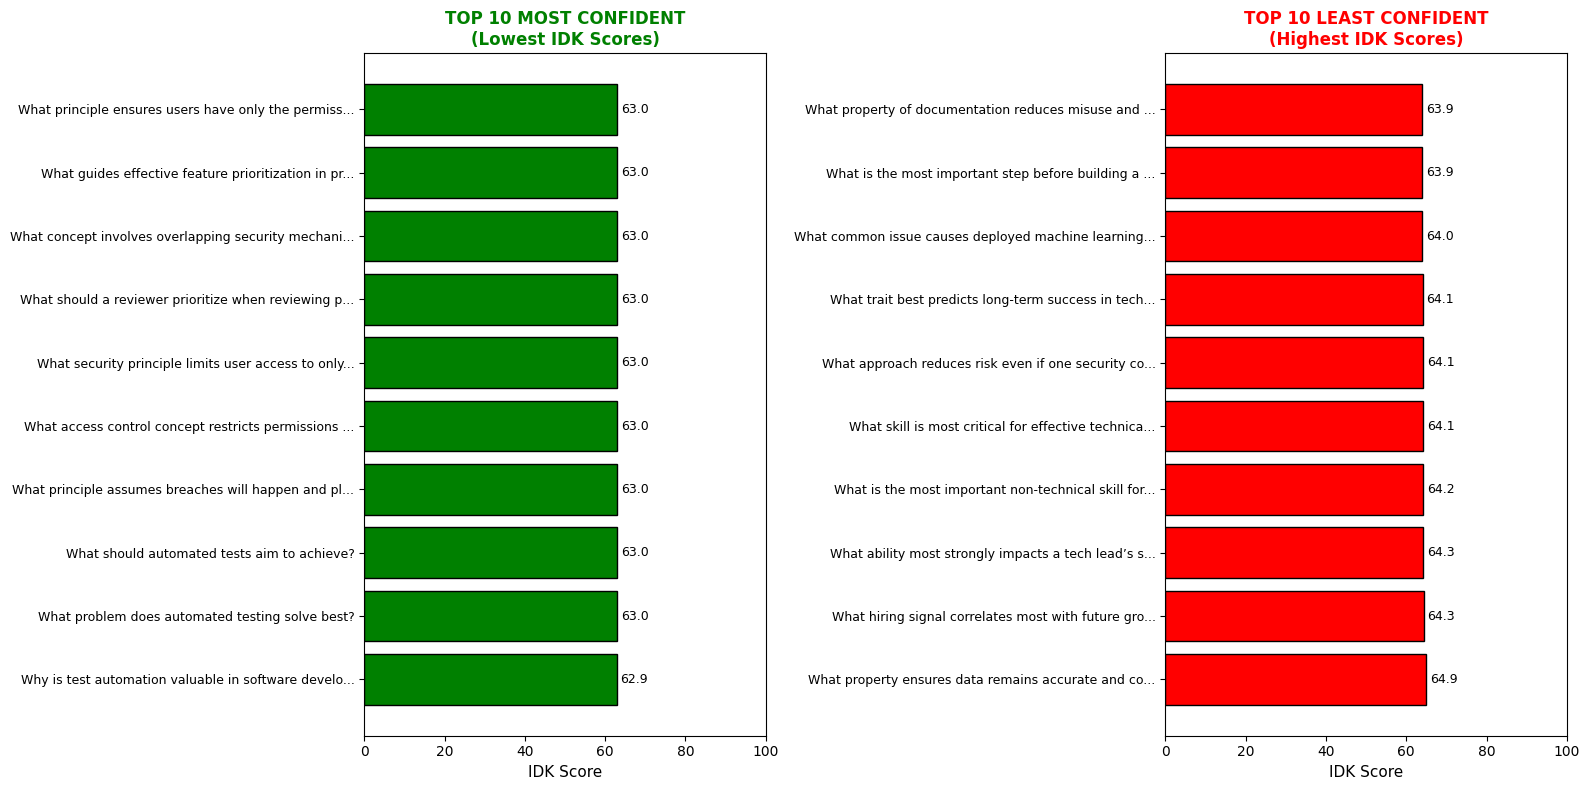

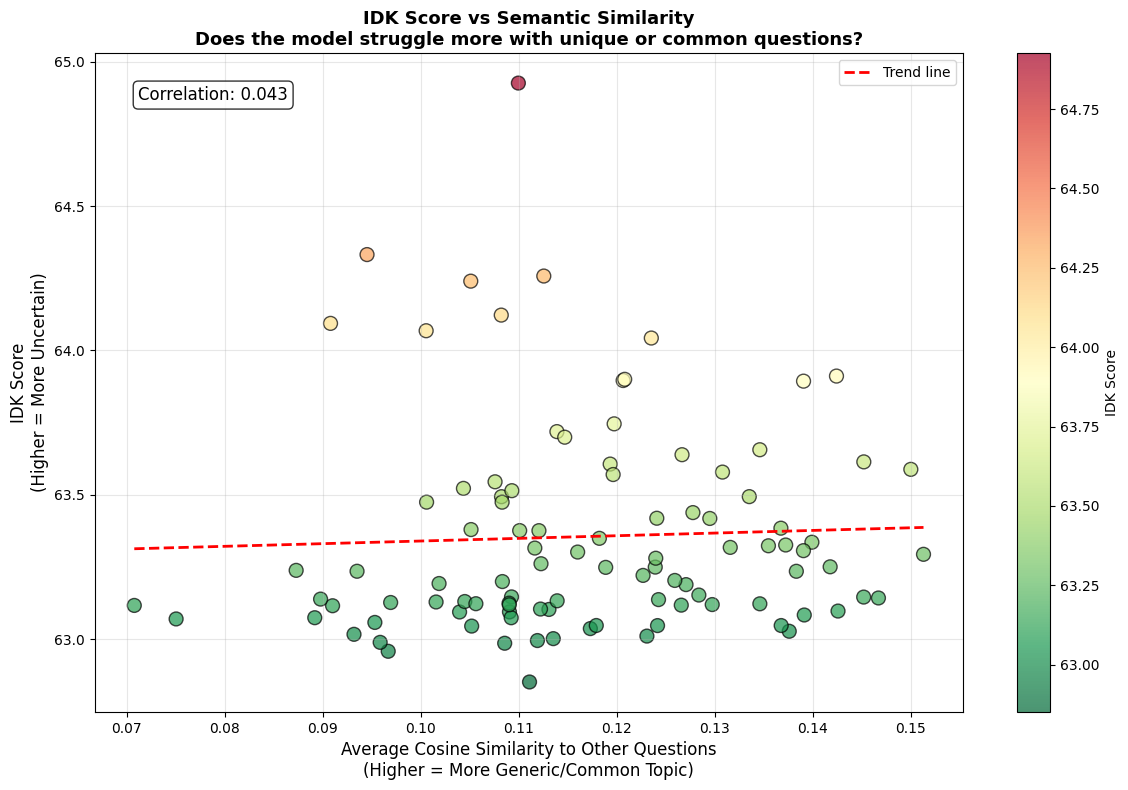


Correlation between average semantic similarity and IDK score: 0.043

IDK SCORES BY TOPIC CATEGORY
                    Mean IDK  Std IDK  Count
category                                    
Testing                63.01     0.12      5
Product Management     63.16     0.10      5
Agile                  63.17     0.18      3
Security               63.18     0.35      9
API Design             63.22     0.21      5
Incident Response      63.23     0.12     10
Code Review            63.23     0.22      5
Other                  63.26     0.40      6
Debugging              63.27     0.13      5
UX Design              63.34     0.20     10
Cloud/Distributed      63.40     0.37      4
Data Engineering       63.50     0.46     16
Documentation          63.50     0.38      5
Hiring/Career          63.73     0.52      3
Machine Learning       63.76     0.21      4
Leadership             63.87     0.47      5


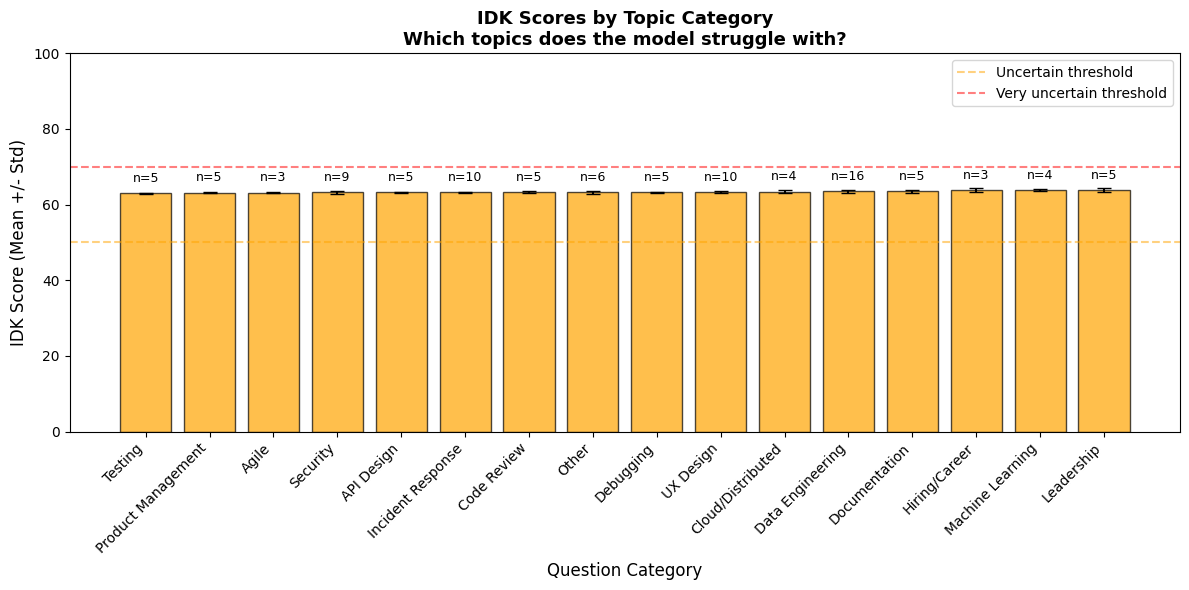

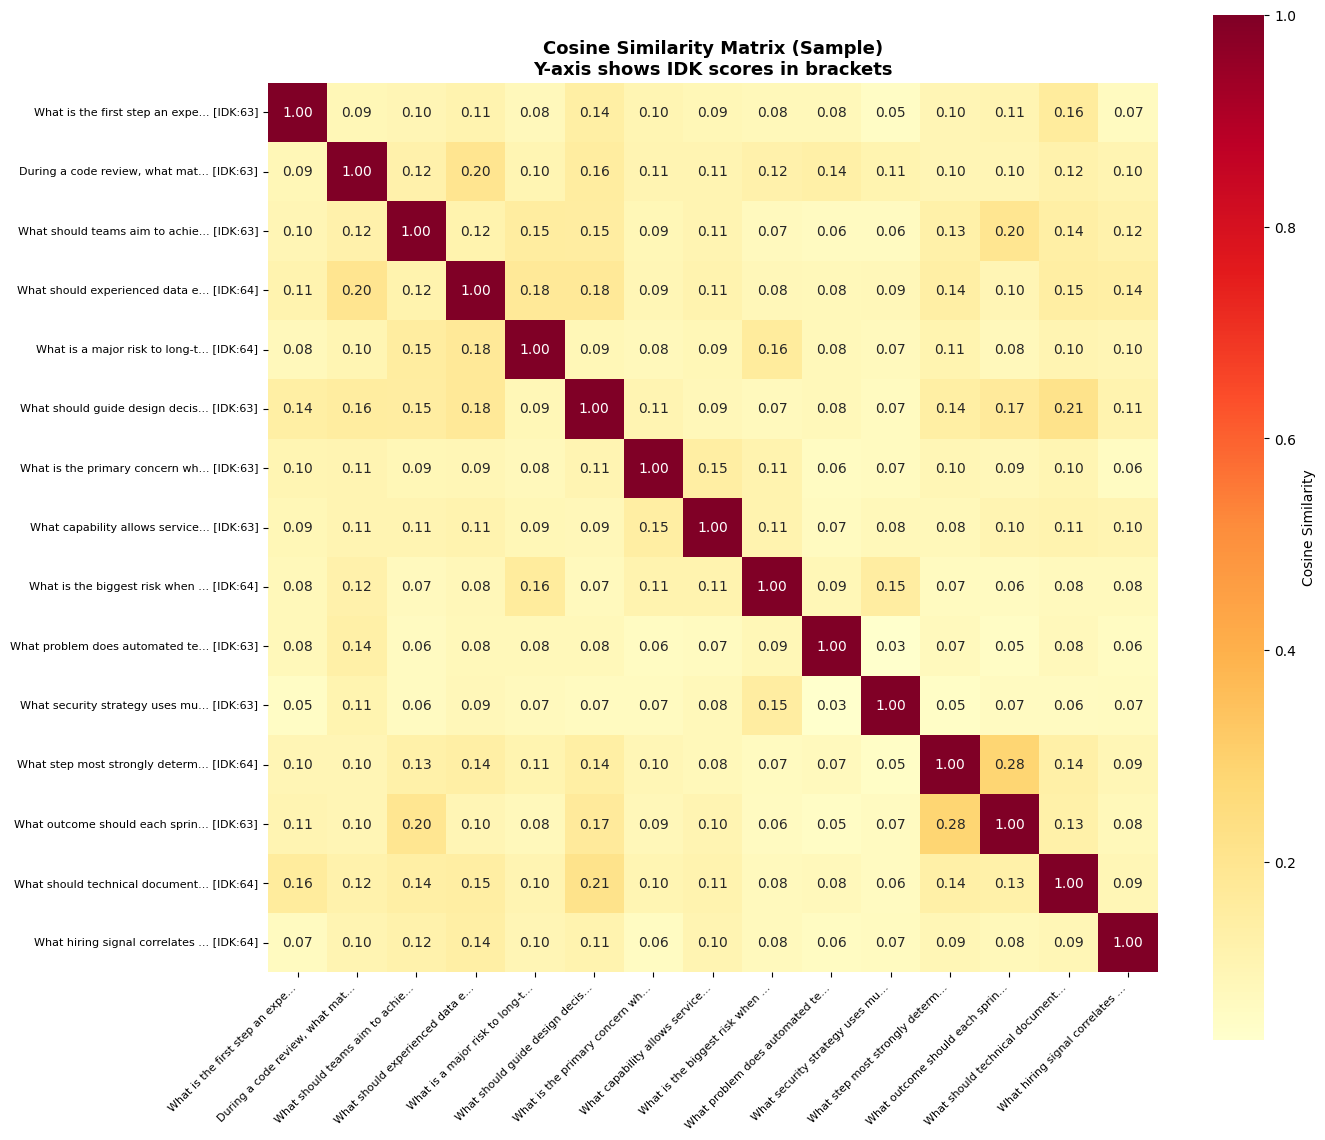

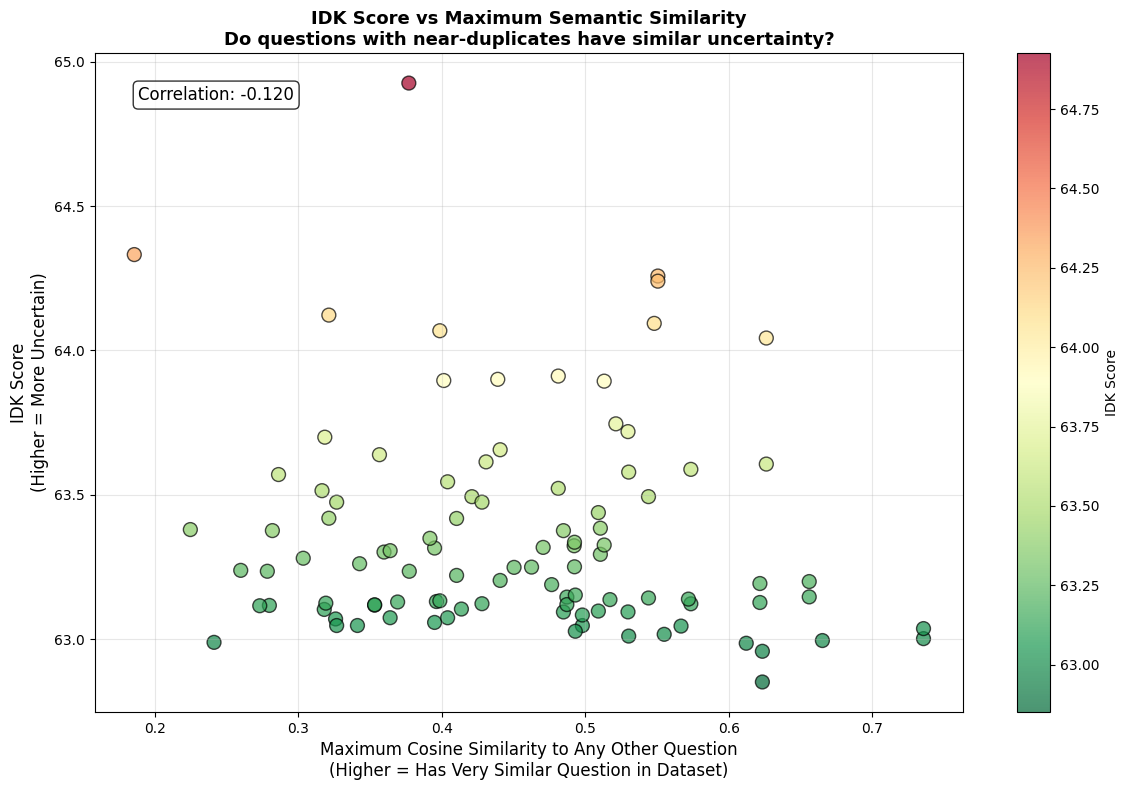


                           SUMMARY

DATASET: 100 software engineering questions
         with pairwise cosine similarity scores

IDK SCORE ANALYSIS:
  - Mean IDK Score:   63.4/100
  - Score Range:      62.9 - 64.9
  - Standard Dev:     0.4

CORRELATION WITH SEMANTIC SIMILARITY:
  - IDK vs Avg Similarity: 0.043
  - IDK vs Max Similarity: -0.120

INTERPRETATION:
  - Positive correlation: Model is more uncertain on generic questions
  - Negative correlation: Model is more uncertain on unique questions
  - Near-zero correlation: IDK is independent of semantic similarity

TOP CONFIDENT CATEGORIES:
                    Mean IDK  Std IDK  Count
category                                    
Testing                63.01     0.12      5
Product Management     63.16     0.10      5
Agile                  63.17     0.18      3

TOP UNCERTAIN CATEGORIES:
                  Mean IDK  Std IDK  Count
category                                  
Hiring/Career        63.73     0.52      3
Machine Learning  

In [ ]:
# =============================================================================
# TEST IDK METRIC AGAINST COSINE SIMILARITY DATA
# =============================================================================
# This cell loads questions from the AI Bullshit Detector dataset and compares
# the IDK (I Don't Know) uncertainty scores with semantic similarity.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load the CSV from GitHub
url = "https://raw.githubusercontent.com/AvdMei/AI_Bullshit_Detector/main/data/output/llm_output_cosine_similarity.csv"
print("Loading cosine similarity data from GitHub...")
df = pd.read_csv(url)

print(f"Loaded matrix: {df.shape[0]} questions x {df.shape[1]} columns")

# The first column contains the questions, rest are similarity scores
questions = df.iloc[:, 0].tolist()
print(f"Found {len(questions)} unique questions")

# Show a few example questions
print("\nExample questions:")
for i, q in enumerate(questions[:5]):
    print(f"  {i+1}. {q[:70]}...")

# =============================================================================
# COMPUTE IDK SCORES FOR ALL QUESTIONS
# =============================================================================

print("\n" + "="*60)
print("Computing IDK scores for all questions...")
print("="*60 + "\n")

def get_idk_score(question):
    """Get IDK score for a single question (fast version - first token only)."""
    prompt = f"<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(input_ids, output_idk_score=True)

    idk = outputs.idk_score
    if isinstance(idk, torch.Tensor):
        idk = idk.item() if idk.numel() == 1 else idk[0].item()
    return idk

# Compute IDK for each question
idk_scores = []
for q in tqdm(questions, desc="Computing IDK scores"):
    try:
        idk = get_idk_score(q)
        idk_scores.append(idk)
    except Exception as e:
        print(f"Error on question: {q[:50]}... - {e}")
        idk_scores.append(None)

# Create results dataframe
results_df = pd.DataFrame({
    'question': questions,
    'idk_score': idk_scores
})

# Remove any failed questions
results_df = results_df.dropna()
print(f"\nSuccessfully computed IDK for {len(results_df)} questions")

# =============================================================================
# FIGURE 1: IDK Score Distribution
# =============================================================================

fig1, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(results_df['idk_score'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(results_df['idk_score'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {results_df['idk_score'].mean():.1f}")
ax1.axvline(results_df['idk_score'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {results_df['idk_score'].median():.1f}")
ax1.set_xlabel('IDK Score', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of IDK Scores Across All Questions', fontsize=13, fontweight='bold')
ax1.legend()
ax1.set_xlim(0, 100)

# Add threshold regions
ax1.axvspan(0, 30, alpha=0.1, color='green', label='Confident')
ax1.axvspan(30, 50, alpha=0.1, color='yellow')
ax1.axvspan(50, 70, alpha=0.1, color='orange')
ax1.axvspan(70, 100, alpha=0.1, color='red')

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(results_df['idk_score'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
ax2.set_ylabel('IDK Score', fontsize=12)
ax2.set_title('IDK Score Box Plot', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 100)

# Add horizontal lines for thresholds
ax2.axhline(30, color='green', linestyle='--', alpha=0.5, label='Confident threshold')
ax2.axhline(50, color='orange', linestyle='--', alpha=0.5, label='Uncertain threshold')
ax2.axhline(70, color='red', linestyle='--', alpha=0.5, label='Very uncertain threshold')
ax2.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "="*60)
print("IDK SCORE STATISTICS")
print("="*60)
print(f"  Mean:   {results_df['idk_score'].mean():.2f}")
print(f"  Median: {results_df['idk_score'].median():.2f}")
print(f"  Std:    {results_df['idk_score'].std():.2f}")
print(f"  Min:    {results_df['idk_score'].min():.2f}")
print(f"  Max:    {results_df['idk_score'].max():.2f}")


# =============================================================================
# FIGURE 2: Top Most/Least Confident Questions
# =============================================================================

fig2, axes = plt.subplots(1, 2, figsize=(16, 8))

# Sort by IDK score
sorted_df = results_df.sort_values('idk_score')

# Most confident (lowest IDK)
n_show = 10
most_confident = sorted_df.head(n_show)
ax_conf = axes[0]
y_pos = range(n_show)
bars = ax_conf.barh(y_pos, most_confident['idk_score'], color='green', edgecolor='black')
ax_conf.set_yticks(y_pos)
ax_conf.set_yticklabels([q[:50] + '...' if len(q) > 50 else q for q in most_confident['question']], fontsize=9)
ax_conf.set_xlabel('IDK Score', fontsize=11)
ax_conf.set_title('TOP 10 MOST CONFIDENT\n(Lowest IDK Scores)', fontsize=12, fontweight='bold', color='green')
ax_conf.set_xlim(0, 100)
for bar, score in zip(bars, most_confident['idk_score']):
    ax_conf.text(score + 1, bar.get_y() + bar.get_height()/2, f'{score:.1f}', va='center', fontsize=9)

# Least confident (highest IDK)
least_confident = sorted_df.tail(n_show).iloc[::-1]
ax_unc = axes[1]
bars = ax_unc.barh(y_pos, least_confident['idk_score'], color='red', edgecolor='black')
ax_unc.set_yticks(y_pos)
ax_unc.set_yticklabels([q[:50] + '...' if len(q) > 50 else q for q in least_confident['question']], fontsize=9)
ax_unc.set_xlabel('IDK Score', fontsize=11)
ax_unc.set_title('TOP 10 LEAST CONFIDENT\n(Highest IDK Scores)', fontsize=12, fontweight='bold', color='red')
ax_unc.set_xlim(0, 100)
for bar, score in zip(bars, least_confident['idk_score']):
    ax_unc.text(score + 1, bar.get_y() + bar.get_height()/2, f'{score:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


# =============================================================================
# FIGURE 3: IDK vs Average Cosine Similarity (Semantic Uniqueness)
# =============================================================================

# Calculate average similarity for each question (excluding self-similarity)
cosine_matrix = df.iloc[:, 1:].values.astype(float)
n_questions = len(questions)

# Average similarity to other questions (measure of how "generic" a question is)
avg_similarities = []
for i in range(n_questions):
    # Get all similarities except self (diagonal = 1.0)
    sims = [cosine_matrix[i, j] for j in range(cosine_matrix.shape[1]) if i != j]
    avg_similarities.append(np.mean(sims))

results_df['avg_cosine_similarity'] = avg_similarities[:len(results_df)]

# Scatter plot
fig3, ax3 = plt.subplots(figsize=(12, 8))

scatter = ax3.scatter(results_df['avg_cosine_similarity'],
                      results_df['idk_score'],
                      c=results_df['idk_score'],
                      cmap='RdYlGn_r',
                      s=100,
                      alpha=0.7,
                      edgecolors='black')

ax3.set_xlabel('Average Cosine Similarity to Other Questions\n(Higher = More Generic/Common Topic)', fontsize=12)
ax3.set_ylabel('IDK Score\n(Higher = More Uncertain)', fontsize=12)
ax3.set_title('IDK Score vs Semantic Similarity\nDoes the model struggle more with unique or common questions?',
              fontsize=13, fontweight='bold')

plt.colorbar(scatter, label='IDK Score')

# Add trend line
z = np.polyfit(results_df['avg_cosine_similarity'], results_df['idk_score'], 1)
p = np.poly1d(z)
x_line = np.linspace(results_df['avg_cosine_similarity'].min(), results_df['avg_cosine_similarity'].max(), 100)
ax3.plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend line')

# Calculate correlation
corr = results_df['avg_cosine_similarity'].corr(results_df['idk_score'])
ax3.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax3.transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.legend()
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCorrelation between average semantic similarity and IDK score: {corr:.3f}")


# =============================================================================
# FIGURE 4: Heatmap - IDK Scores by Question Topic Clusters
# =============================================================================

# Group questions by topic (based on keywords)
def categorize_question(q):
    q_lower = q.lower()
    if 'bug' in q_lower or 'debug' in q_lower or 'fix' in q_lower:
        return 'Debugging'
    elif 'code review' in q_lower or 'reviewer' in q_lower:
        return 'Code Review'
    elif 'incident' in q_lower or 'outage' in q_lower or 'postmortem' in q_lower:
        return 'Incident Response'
    elif 'security' in q_lower or 'access' in q_lower or 'permission' in q_lower:
        return 'Security'
    elif 'data' in q_lower or 'pipeline' in q_lower or 'data science' in q_lower:
        return 'Data Engineering'
    elif 'machine learning' in q_lower or 'ml' in q_lower or 'model' in q_lower:
        return 'Machine Learning'
    elif 'product' in q_lower or 'feature' in q_lower or 'roadmap' in q_lower:
        return 'Product Management'
    elif 'design' in q_lower or 'ux' in q_lower or 'interface' in q_lower:
        return 'UX Design'
    elif 'database' in q_lower or 'transaction' in q_lower:
        return 'Database'
    elif 'cloud' in q_lower or 'distributed' in q_lower or 'scale' in q_lower:
        return 'Cloud/Distributed'
    elif 'leadership' in q_lower or 'team' in q_lower or 'tech lead' in q_lower:
        return 'Leadership'
    elif 'api' in q_lower:
        return 'API Design'
    elif 'test' in q_lower or 'automation' in q_lower:
        return 'Testing'
    elif 'agile' in q_lower or 'sprint' in q_lower:
        return 'Agile'
    elif 'documentation' in q_lower:
        return 'Documentation'
    elif 'hiring' in q_lower or 'interview' in q_lower or 'engineer' in q_lower:
        return 'Hiring/Career'
    else:
        return 'Other'

results_df['category'] = results_df['question'].apply(categorize_question)

# Group statistics
category_stats = results_df.groupby('category').agg({
    'idk_score': ['mean', 'std', 'count']
}).round(2)
category_stats.columns = ['Mean IDK', 'Std IDK', 'Count']
category_stats = category_stats.sort_values('Mean IDK')

print("\n" + "="*60)
print("IDK SCORES BY TOPIC CATEGORY")
print("="*60)
print(category_stats.to_string())

# Bar chart by category
fig4, ax4 = plt.subplots(figsize=(12, 6))

categories = category_stats.index.tolist()
means = category_stats['Mean IDK'].tolist()
stds = category_stats['Std IDK'].tolist()
counts = category_stats['Count'].tolist()

# Color based on mean IDK
colors = ['green' if m < 50 else 'orange' if m < 65 else 'red' for m in means]

bars = ax4.bar(range(len(categories)), means, yerr=stds, capsize=5,
               color=colors, edgecolor='black', alpha=0.7)

ax4.set_xticks(range(len(categories)))
ax4.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax4.set_ylabel('IDK Score (Mean +/- Std)', fontsize=12)
ax4.set_xlabel('Question Category', fontsize=12)
ax4.set_title('IDK Scores by Topic Category\nWhich topics does the model struggle with?',
              fontsize=13, fontweight='bold')
ax4.set_ylim(0, 100)

# Add count labels
for bar, count in zip(bars, counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
             f'n={count}', ha='center', fontsize=9)

# Add threshold lines
ax4.axhline(50, color='orange', linestyle='--', alpha=0.5, label='Uncertain threshold')
ax4.axhline(70, color='red', linestyle='--', alpha=0.5, label='Very uncertain threshold')
ax4.legend(loc='upper right')

plt.tight_layout()
plt.show()


# =============================================================================
# FIGURE 5: Cosine Similarity Heatmap with IDK Annotations
# =============================================================================

# Create a smaller heatmap with IDK scores as annotations
# Select a subset of diverse questions for readability
n_sample = 15
sample_indices = np.linspace(0, len(questions)-1, n_sample, dtype=int)

sample_questions = [questions[i][:30] + '...' for i in sample_indices]
sample_idk = [idk_scores[i] for i in sample_indices]
sample_cosine = cosine_matrix[sample_indices][:, sample_indices]

fig5, ax5 = plt.subplots(figsize=(14, 12))

# Heatmap
sns.heatmap(sample_cosine,
            xticklabels=sample_questions,
            yticklabels=[f"{q} [IDK:{idk:.0f}]" for q, idk in zip(sample_questions, sample_idk)],
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            square=True,
            cbar_kws={'label': 'Cosine Similarity'},
            ax=ax5)

ax5.set_title('Cosine Similarity Matrix (Sample)\nY-axis shows IDK scores in brackets',
              fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


# =============================================================================
# FIGURE 6: IDK Score vs Max Similarity (Finding Similar Questions)
# =============================================================================

# For each question, find its max similarity to any other question
max_similarities = []
for i in range(n_questions):
    sims = [cosine_matrix[i, j] for j in range(cosine_matrix.shape[1]) if i != j]
    max_similarities.append(max(sims) if sims else 0)

results_df['max_cosine_similarity'] = max_similarities[:len(results_df)]

fig6, ax6 = plt.subplots(figsize=(12, 8))

scatter = ax6.scatter(results_df['max_cosine_similarity'],
                      results_df['idk_score'],
                      c=results_df['idk_score'],
                      cmap='RdYlGn_r',
                      s=100,
                      alpha=0.7,
                      edgecolors='black')

ax6.set_xlabel('Maximum Cosine Similarity to Any Other Question\n(Higher = Has Very Similar Question in Dataset)', fontsize=12)
ax6.set_ylabel('IDK Score\n(Higher = More Uncertain)', fontsize=12)
ax6.set_title('IDK Score vs Maximum Semantic Similarity\nDo questions with near-duplicates have similar uncertainty?',
              fontsize=13, fontweight='bold')

plt.colorbar(scatter, label='IDK Score')

# Correlation
corr_max = results_df['max_cosine_similarity'].corr(results_df['idk_score'])
ax6.text(0.05, 0.95, f'Correlation: {corr_max:.3f}', transform=ax6.transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax6.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================================
# SUMMARY
# =============================================================================

print("\n" + "="*70)
print("                           SUMMARY")
print("="*70)
print(f"""
DATASET: {len(questions)} software engineering questions
         with pairwise cosine similarity scores

IDK SCORE ANALYSIS:
  - Mean IDK Score:   {results_df['idk_score'].mean():.1f}/100
  - Score Range:      {results_df['idk_score'].min():.1f} - {results_df['idk_score'].max():.1f}
  - Standard Dev:     {results_df['idk_score'].std():.1f}

CORRELATION WITH SEMANTIC SIMILARITY:
  - IDK vs Avg Similarity: {corr:.3f}
  - IDK vs Max Similarity: {corr_max:.3f}

INTERPRETATION:
  - Positive correlation: Model is more uncertain on generic questions
  - Negative correlation: Model is more uncertain on unique questions
  - Near-zero correlation: IDK is independent of semantic similarity

TOP CONFIDENT CATEGORIES:
{category_stats.head(3).to_string()}

TOP UNCERTAIN CATEGORIES:
{category_stats.tail(3).to_string()}
""")
print("="*70)

## save the model weights for HuggingFace

In [ ]:
import torch
from google.colab import files

torch.save(model.idk_head.state_dict(), "pytorch_model.bin")
files.download("pytorch_model.bin")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Demo the Liquid AI model and Bullshit Detector in action

In [ ]:


QUESTION = "What will I do tomorrow?"

# ============================================

# Template for LFM2
template = "<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"

# Encode
prompt = template.format(question=QUESTION)
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(DEVICE)

# Generate with IDK tracking
generated_tokens = []
idk_scores = []
current = input_ids
past = None

model.eval()
for _ in range(50):  # max tokens
    with torch.no_grad():
        outputs = model(current, past_key_values=past, output_idk_score=True)

    # Get IDK score
    idk = outputs.idk_score
    if isinstance(idk, torch.Tensor):
        idk = idk.item() if idk.numel() == 1 else idk[0].item()
    idk_scores.append(idk)

    # Sample next token
    logits = outputs.logits[:, -1, :]
    probs = F.softmax(logits / 0.3, dim=-1)  # temperature=0.3
    next_token = torch.multinomial(probs, num_samples=1)

    generated_tokens.append(next_token.item())

    # Check EOS
    if next_token.item() == tokenizer.eos_token_id:
        break

    past = outputs.past_key_values
    current = next_token

# Decode answer
answer = tokenizer.decode(generated_tokens, skip_special_tokens=True)
mean_idk = sum(idk_scores) / len(idk_scores) if idk_scores else 0

# Get label
if mean_idk < 30:
    label = "[GREEN] Confident"
elif mean_idk < 50:
    label = "[YELLOW] Moderate"
elif mean_idk < 70:
    label = "[ORANGE] Uncertain"
else:
    label = "[RED] Very Uncertain"

# Display results
print("=" * 60)
print("QUESTION:", QUESTION)
print("-" * 60)
print("ANSWER:", answer)
print("-" * 60)
print("IDK SCORE: {:.1f}/100 - {}".format(mean_idk, label))
print("=" * 60)
print("")
print("IDK Score Guide:")
print("  0-30  = Confident (likely reliable)")
print("  30-50 = Moderate (probably fine)")
print("  50-70 = Uncertain (verify this)")
print("  70-100 = Very Uncertain (high hallucination risk)")

QUESTION: What will I do tomorrow?
------------------------------------------------------------
ANSWER: Tomorrow, I'll be helping you organize your thoughts and tasks. Since I can't physically do things, I'll guide you through planning your day. Here's a general outline:

1. **Review Your Schedule**: Check what's already
------------------------------------------------------------
IDK SCORE: 64.0/100 - [ORANGE] Uncertain

IDK Score Guide:
  0-30  = Confident (likely reliable)
  30-50 = Moderate (probably fine)
  50-70 = Uncertain (verify this)
  70-100 = Very Uncertain (high hallucination risk)


# Optional: model diagnostics

In [ ]:
model = AutoModelForCausalLM.from_pretrained("LiquidAI/LFM2-1.2B", device_map="auto")

# Check model structure
print("Model type:", type(model))
print("\nNamed modules:")
for name, module in model.named_modules():
    if 'layer' in name.lower() or 'block' in name.lower():
        print(f"  {name}: {type(module).__name__}")

# Check past_key_values structure
input_ids = tokenizer.encode("Hello", return_tensors="pt").to(model.device)
with torch.no_grad():
    outputs = model(input_ids, use_cache=True, output_hidden_states=True)

print(f"\nHidden states: {len(outputs.hidden_states)} tensors")
print(f"Past key values: {len(outputs.past_key_values)} layers")

for i, kv in enumerate(outputs.past_key_values):
    if kv is not None and isinstance(kv, tuple) and len(kv) >= 2:
        k, v = kv[0], kv[1]
        print(f"  Layer {i}: K={k.shape}, V={v.shape}")
    else:
        print(f"  Layer {i}: {type(kv)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

Liquid AI's LFM2-1.2B